In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from scipy.special import j1  # Bessel function of the first kind
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter,median_filter

from scipy.optimize import minimize, NonlinearConstraint

import matplotlib.cm

import seaborn as sns
from matplotlib.colors import to_rgb

In [2]:
def visibility_ideal(theta, B, lam):
    """
    Calculate squared visibility for a uniform disk.

    Parameters:
        theta : float
            Angular diameter [mas]
        B : float or ndarray
            Baseline in meters
        lam : float or ndarray
            Wavelength(s) in meters

    Returns:
        V : float or ndarray
            NOrmalized visibility
    """
    x = np.pi * theta/1000/3600/180*np.pi * B / lam
    V = 2 * j1(x) / x
    return V

ind = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

def calibrate_vis(params, vis, flux, v_ideal):
    a = params[:4]
    b = params[4:]
    v = np.empty_like(vis)
    for i, (i1, i2) in enumerate(ind):
        v[:, :, i] = b[i] * vis[:, :, i] / np.sqrt(
            a[i1] * flux[:, :, i1] * a[i2] * flux[:, :, i2]
        )
    # Return scalar: sum of squared residuals
    return np.sum((v - v_ideal)**2)

def flux_constraint(params, vis, flux):
    a = params[:4]
    b = params[4:]
    left = np.sum(b[None, None, :] * vis, axis=-1) + np.sum(a[None, None, :] * flux, axis=-1)
    right = np.sum(vis, axis=-1) + np.sum(flux, axis=-1)
    return (left - right).sum()

In [21]:
root = "/home/sauter/PhD/beta Pic/astroreduced_stdpipe/astroreduced_stdpipe/"

all_files = os.listdir(root)
files = []
for file in all_files:
    if "ASTROREDUCED" in file and "BetaPic" in file:
        files.append(file)
files.sort()

vis = np.empty((18,16,6,1628),dtype=np.complex128)
flux = np.empty((18,16,4,1628))
v_ideal = np.empty((18,16,6,1628))
vis_ft = np.empty((18,16,6,6),dtype=np.complex128)

AM = []
WS = []
Temp = []
PWV = []
Theta0 = []
Seeing = []
Tau0 = []
Pressure = []
Time = []

baseline_labels = ["34", "24", "14", "23", "13", "12"]
theta = 0.66686687
j = 0
for file in files:
    if fits.open(root+file)[0].header["HIERARCH ESO DET2 SEQ1 DIT"] == 3:

        vis[j] = fits.open(root+file)[5].data["VISDATA"].reshape(16,6,1628)
        vis_ft[j] = fits.open(root+file)[5].data["VISDATA_FT"].reshape(16,6,6)
        flux[j] = fits.open(root+file)[7].data["FLUX"].reshape(16,4,1628)
        wave = fits.open(root+file)[1].data["EFF_WAVE"]
        wave_ft = fits.open(root+file)[2].data["EFF_WAVE"]
        h = fits.open(root+file)[0].header

        AM.append((h["HIERARCH ESO ISS AIRM END"]+h["HIERARCH ESO ISS AIRM END"])/2)
        WS.append(h["HIERARCH ESO ISS AMBI WINDSP"])
        Temp.append(h["HIERARCH ESO ISS AMBI TEMP"])
        PWV.append(0.5*(h["HIERARCH ESO ISS AMBI IWV START"]+h["HIERARCH ESO ISS AMBI IWV END"]))
        Theta0.append(0.5*(h["HIERARCH ESO ISS AMBI THETA0 START"]+h["HIERARCH ESO ISS AMBI THETA0 END"]))
        Seeing.append(0.5*(h["HIERARCH ESO ISS AMBI FWHM START"]+h["HIERARCH ESO ISS AMBI FWHM END"]))
        Tau0.append(0.5*(h["HIERARCH ESO ISS AMBI TAU0 START"]+h["HIERARCH ESO ISS AMBI TAU0 END"]))
        Pressure.append(h["HIERARCH ESO ISS AMBI PRES"])
        Time.append(h['MJD-OBS'])

        for i in range(6):
            bl_start = h[f"HIERARCH ESO ISS PBL{baseline_labels[i]} START"]
            bl_end = h[f"HIERARCH ESO ISS PBL{baseline_labels[i]} END"]
            for k in range(16):
                bl = bl_start + k/15*(bl_end-bl_start)
                v_ideal[j,k,i] = visibility_ideal(theta, bl, wave)
        j += 1

"""
# Initial guess
params0 = np.ones(10)

params_opt = np.empty((10,1628))
params_res = np.empty((1628))
for i in range(1628):
    print(i)
    # Nonlinear constraint
    constraint = NonlinearConstraint(lambda p: flux_constraint(p, np.abs(vis[:,:,:,i]), flux[:,:,:,i]), 0, 0)

    # Run optimization
    result = minimize(
        calibrate_vis,
        params0,
        args=(np.abs(vis[:,:,:,i]), flux[:,:,:,i], v_ideal[:,:,:,i]),
        constraints=[constraint],
        bounds=[(0.5, 2.0)] * 10,
        method='trust-constr',
        options={'gtol': 1e-10, 'xtol': 1e-10, 'verbose': 1}
    )

    params_opt[:,i] = result.x
    print(result.x)

    params_res[i] = calibrate_vis(result.x, np.abs(vis[:,:,:,i]), flux[:,:,:,i], v_ideal[:,:,:,i])

plt.figure()
plt.plot(wave,params_res)
plt.show()
"""

"\n# Initial guess\nparams0 = np.ones(10)\n\nparams_opt = np.empty((10,1628))\nparams_res = np.empty((1628))\nfor i in range(1628):\n    print(i)\n    # Nonlinear constraint\n    constraint = NonlinearConstraint(lambda p: flux_constraint(p, np.abs(vis[:,:,:,i]), flux[:,:,:,i]), 0, 0)\n\n    # Run optimization\n    result = minimize(\n        calibrate_vis,\n        params0,\n        args=(np.abs(vis[:,:,:,i]), flux[:,:,:,i], v_ideal[:,:,:,i]),\n        constraints=[constraint],\n        bounds=[(0.5, 2.0)] * 10,\n        method='trust-constr',\n        options={'gtol': 1e-10, 'xtol': 1e-10, 'verbose': 1}\n    )\n\n    params_opt[:,i] = result.x\n    print(result.x)\n\n    params_res[i] = calibrate_vis(result.x, np.abs(vis[:,:,:,i]), flux[:,:,:,i], v_ideal[:,:,:,i])\n\nplt.figure()\nplt.plot(wave,params_res)\nplt.show()\n"

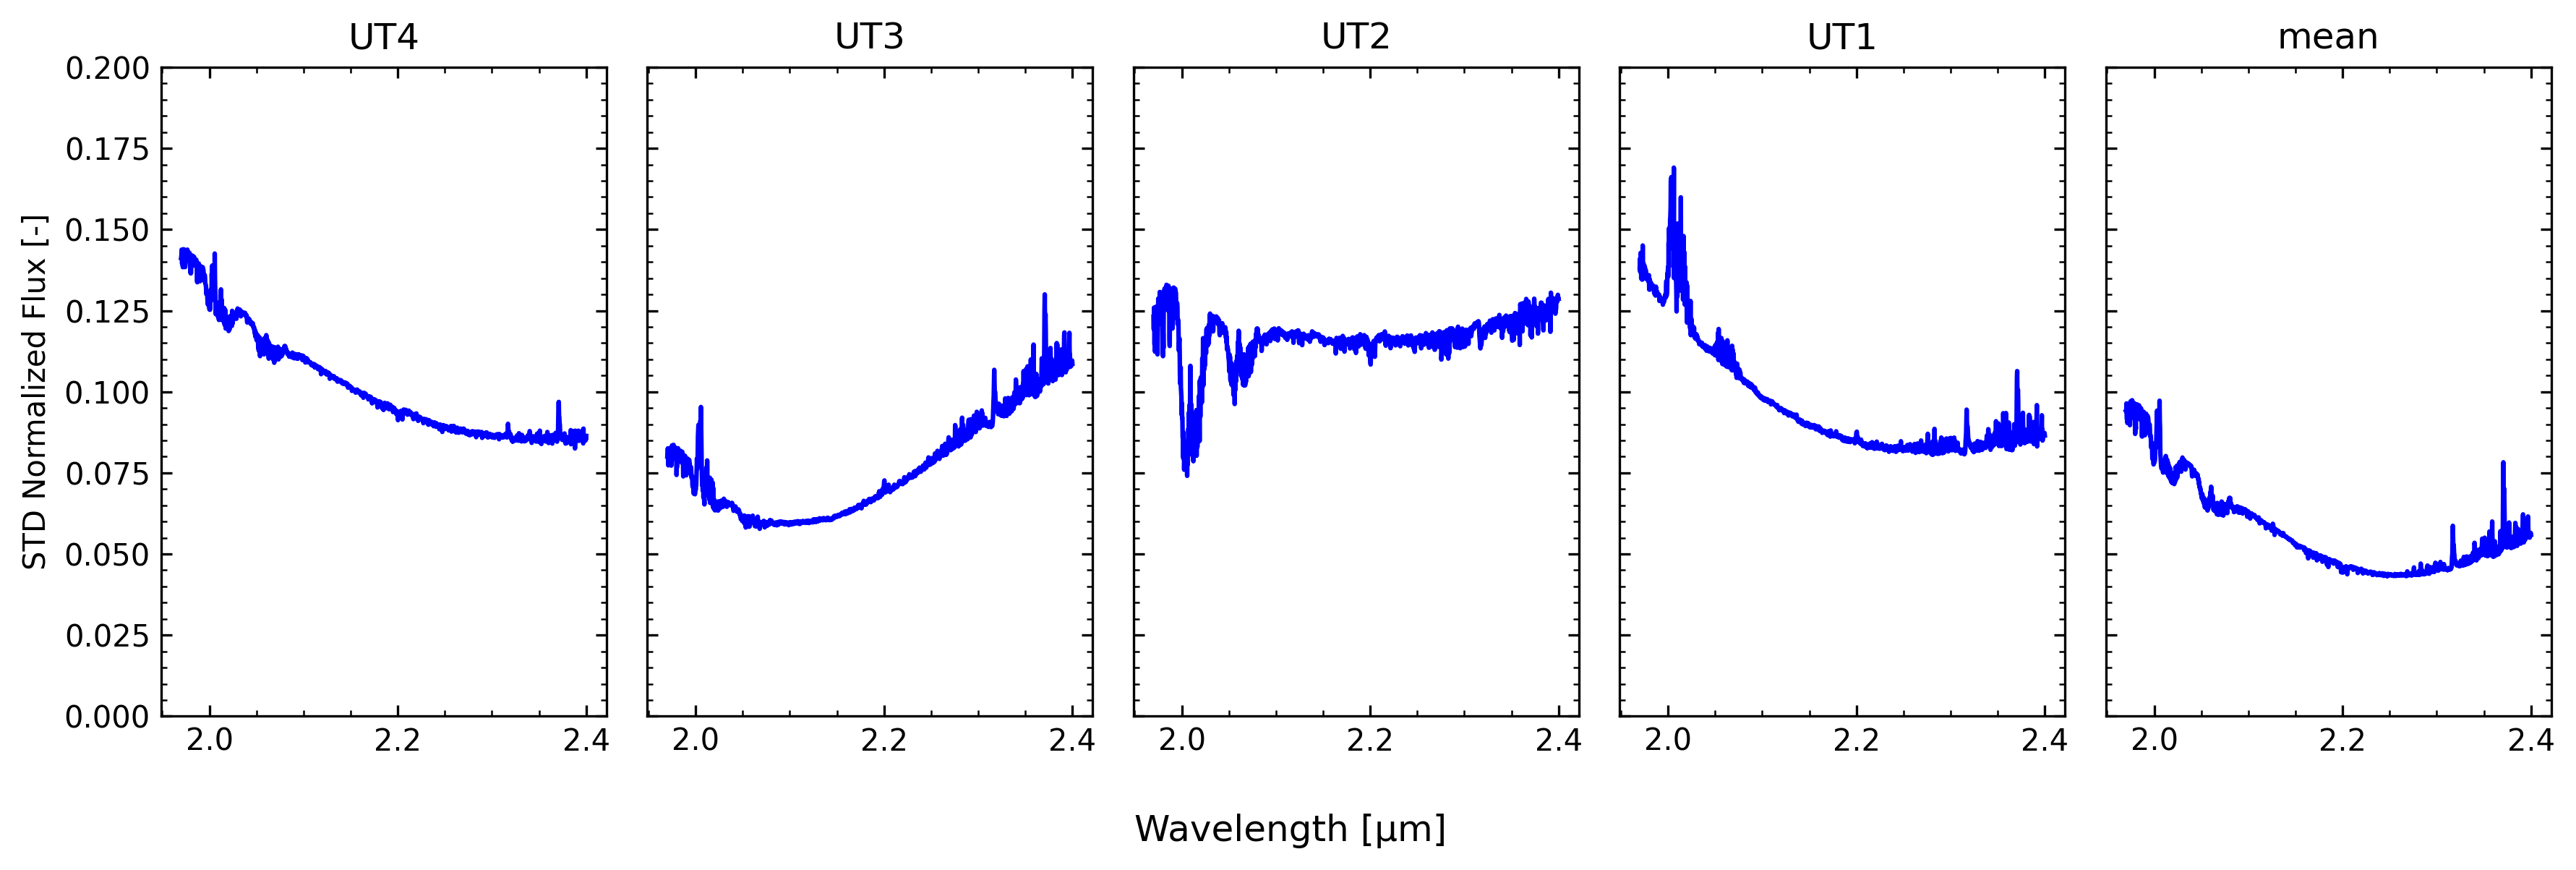

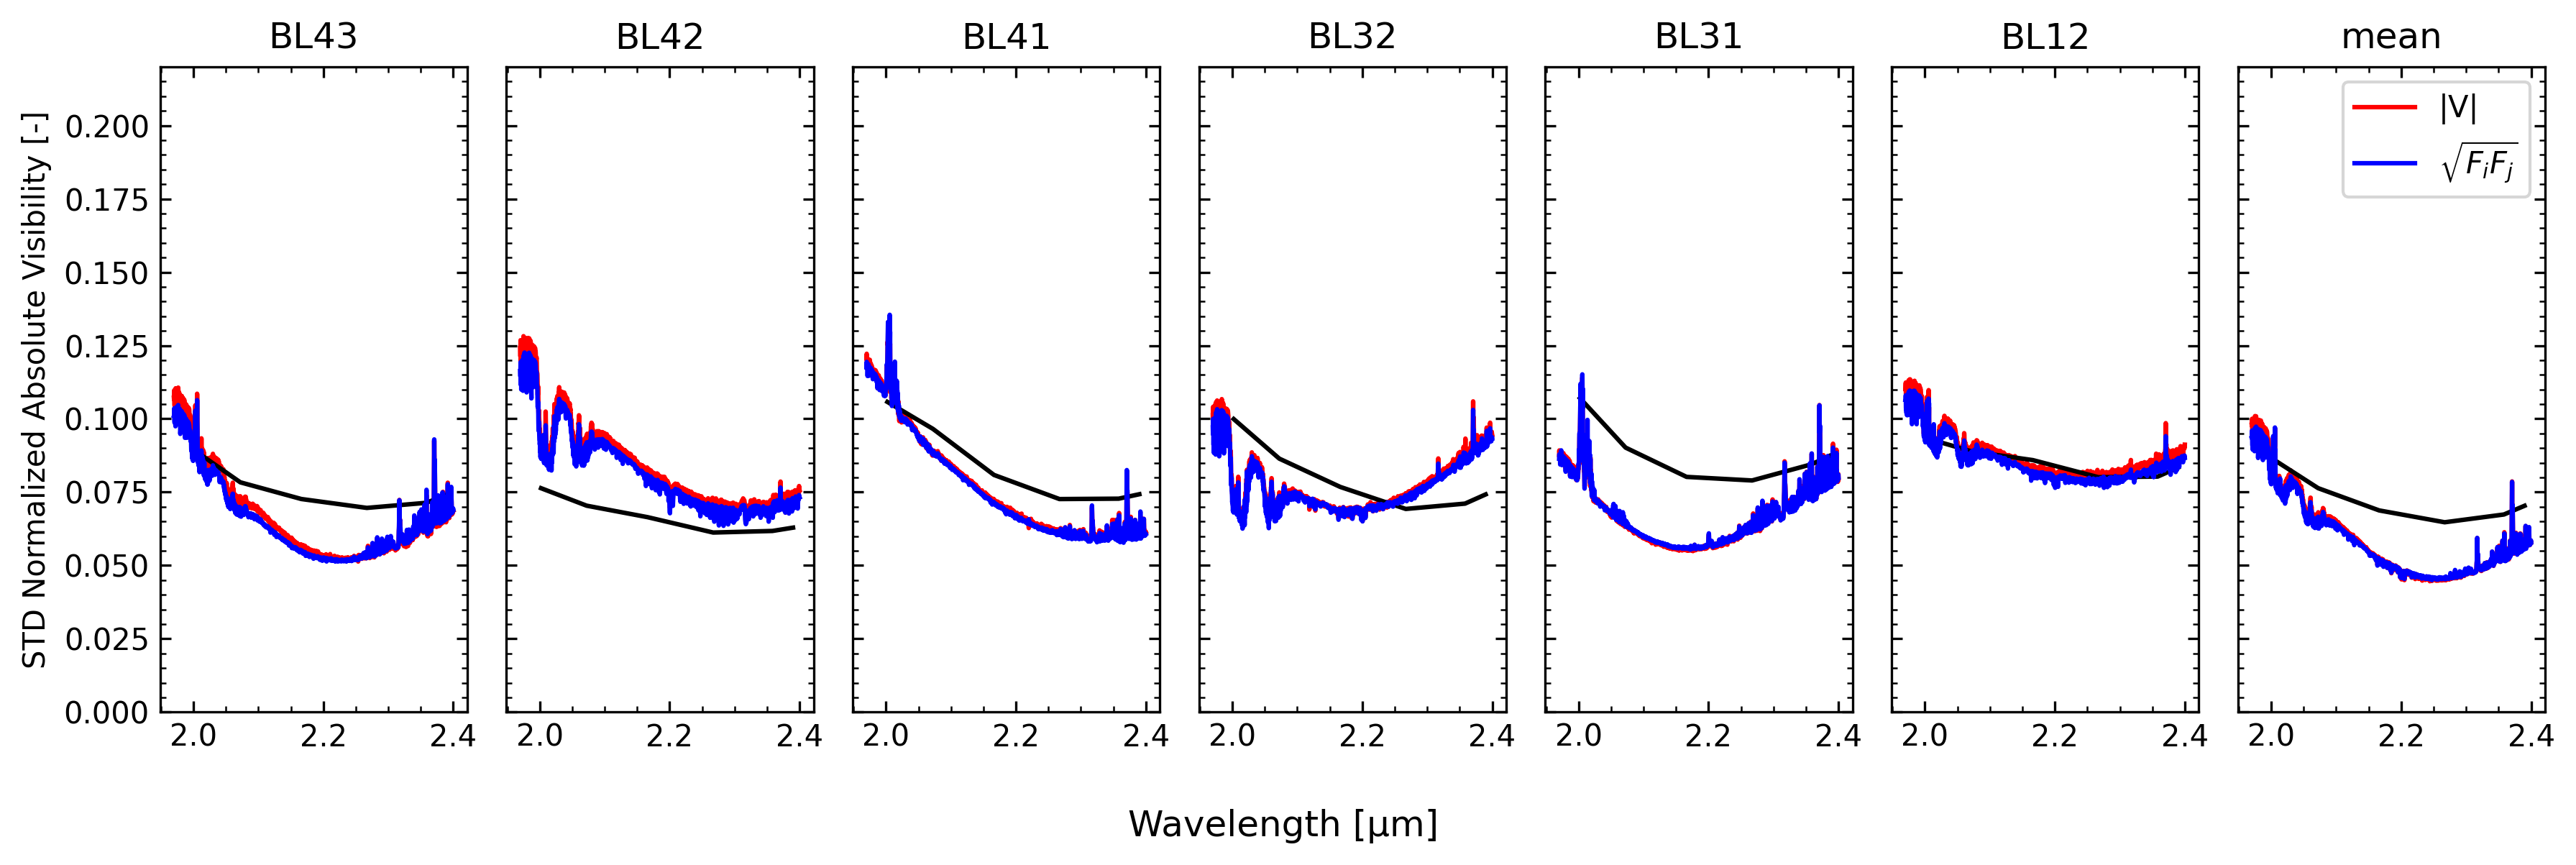

In [28]:
labels = ['UT4','UT3','UT2','UT1']

fig,ax = plt.subplots(1,5,dpi=300,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.std(np.mean(flux,axis=1)[:,i]/np.mean(np.mean(flux,axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.std(np.mean(np.mean(flux,axis=1),axis=1)/np.mean(np.mean(flux,axis=1),axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('STD Normalized Flux [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.2])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

vis_flux = np.empty((18,16,6,1628))
for i in range(6):
    t1 = ind[i][0]
    t2 = ind[i][1]
    vis_flux[:,:,i] = np.sqrt(flux[:,:,t1]*flux[:,:,t2])

bl_labels = ["BL43","BL42","BL41","BL32","BL31","BL12"]

fig,ax = plt.subplots(1,7,dpi=300,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave*1e6,np.std(np.mean(np.abs(vis),axis=1)[:,i]/np.mean(np.mean(np.abs(vis),axis=1)[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave_ft*1e6,np.std(np.mean(np.abs(vis_ft),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_ft),axis=1)[:,i],axis=0)[None,:],axis=0),color='black')
    ax[i].plot(wave*1e6,np.std(np.mean(np.abs(vis_flux),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_flux),axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
ax[6].plot(wave*1e6,np.std(np.mean(np.mean(np.abs(vis),axis=1),axis=1)/np.mean(np.mean(np.abs(vis),axis=1),axis=(0,1))[None,:],axis=0),color='red',label='|V|')
ax[6].plot(wave_ft*1e6,np.std(np.mean(np.mean(np.abs(vis_ft),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_ft),axis=1),axis=(0,1))[None,:],axis=0),color='black')
ax[6].plot(wave*1e6,np.std(np.mean(np.mean(np.abs(vis_flux),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_flux),axis=1),axis=(0,1))[None,:],axis=0),color='blue',label='$\sqrt{F_iF_j}$')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('STD Normalized Absolute Visibility [-]')
ax[0].set_ylim([0.0,0.22])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

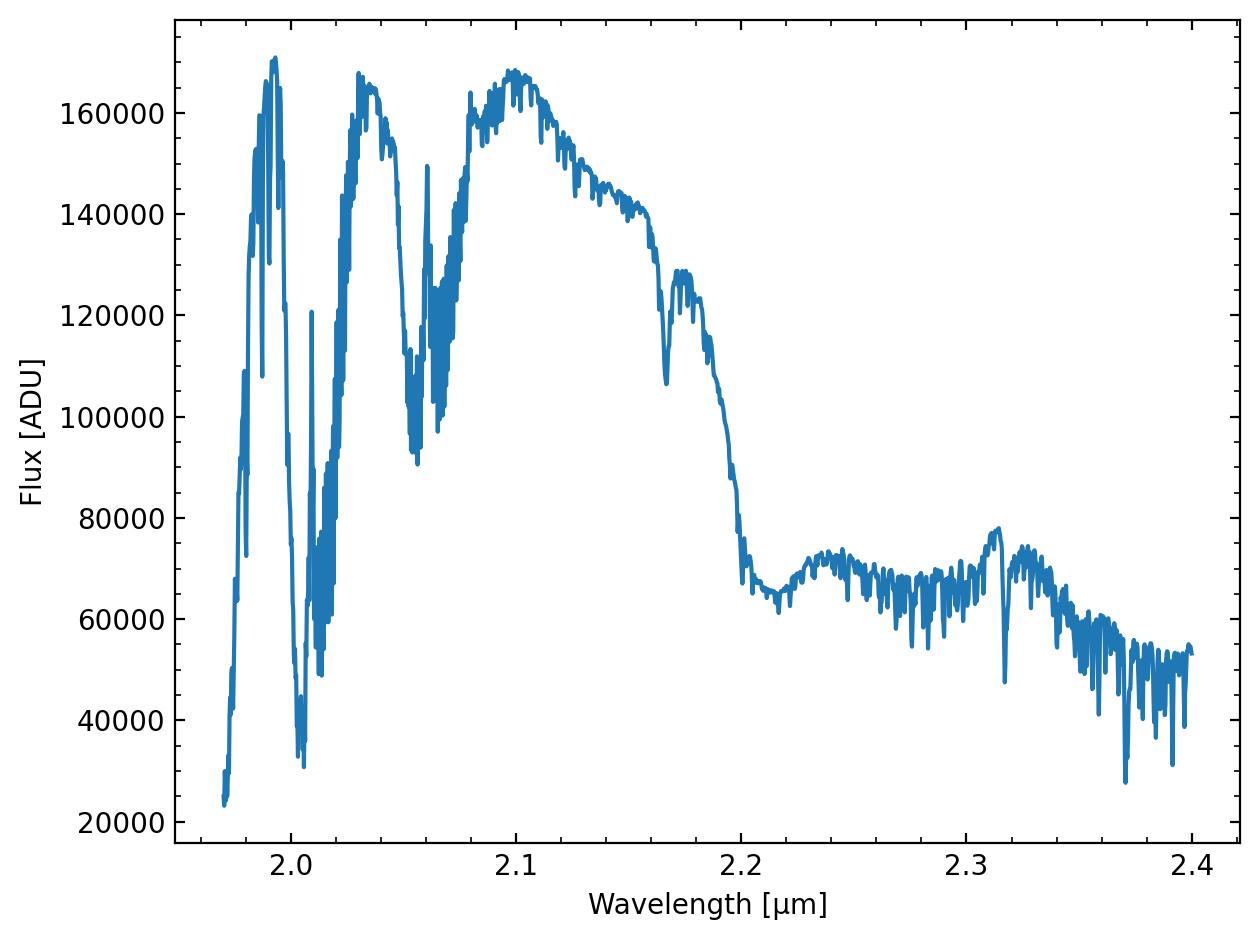

In [5]:
fig,ax = plt.subplots(dpi=200)
ax.plot(wave*1e6,np.mean(flux,axis=(0,1,2)))
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.minorticks_on()
ax.set_ylabel('Flux [ADU]')
ax.set_xlabel('Wavelength [µm]')
plt.tight_layout()
plt.show()

1.532


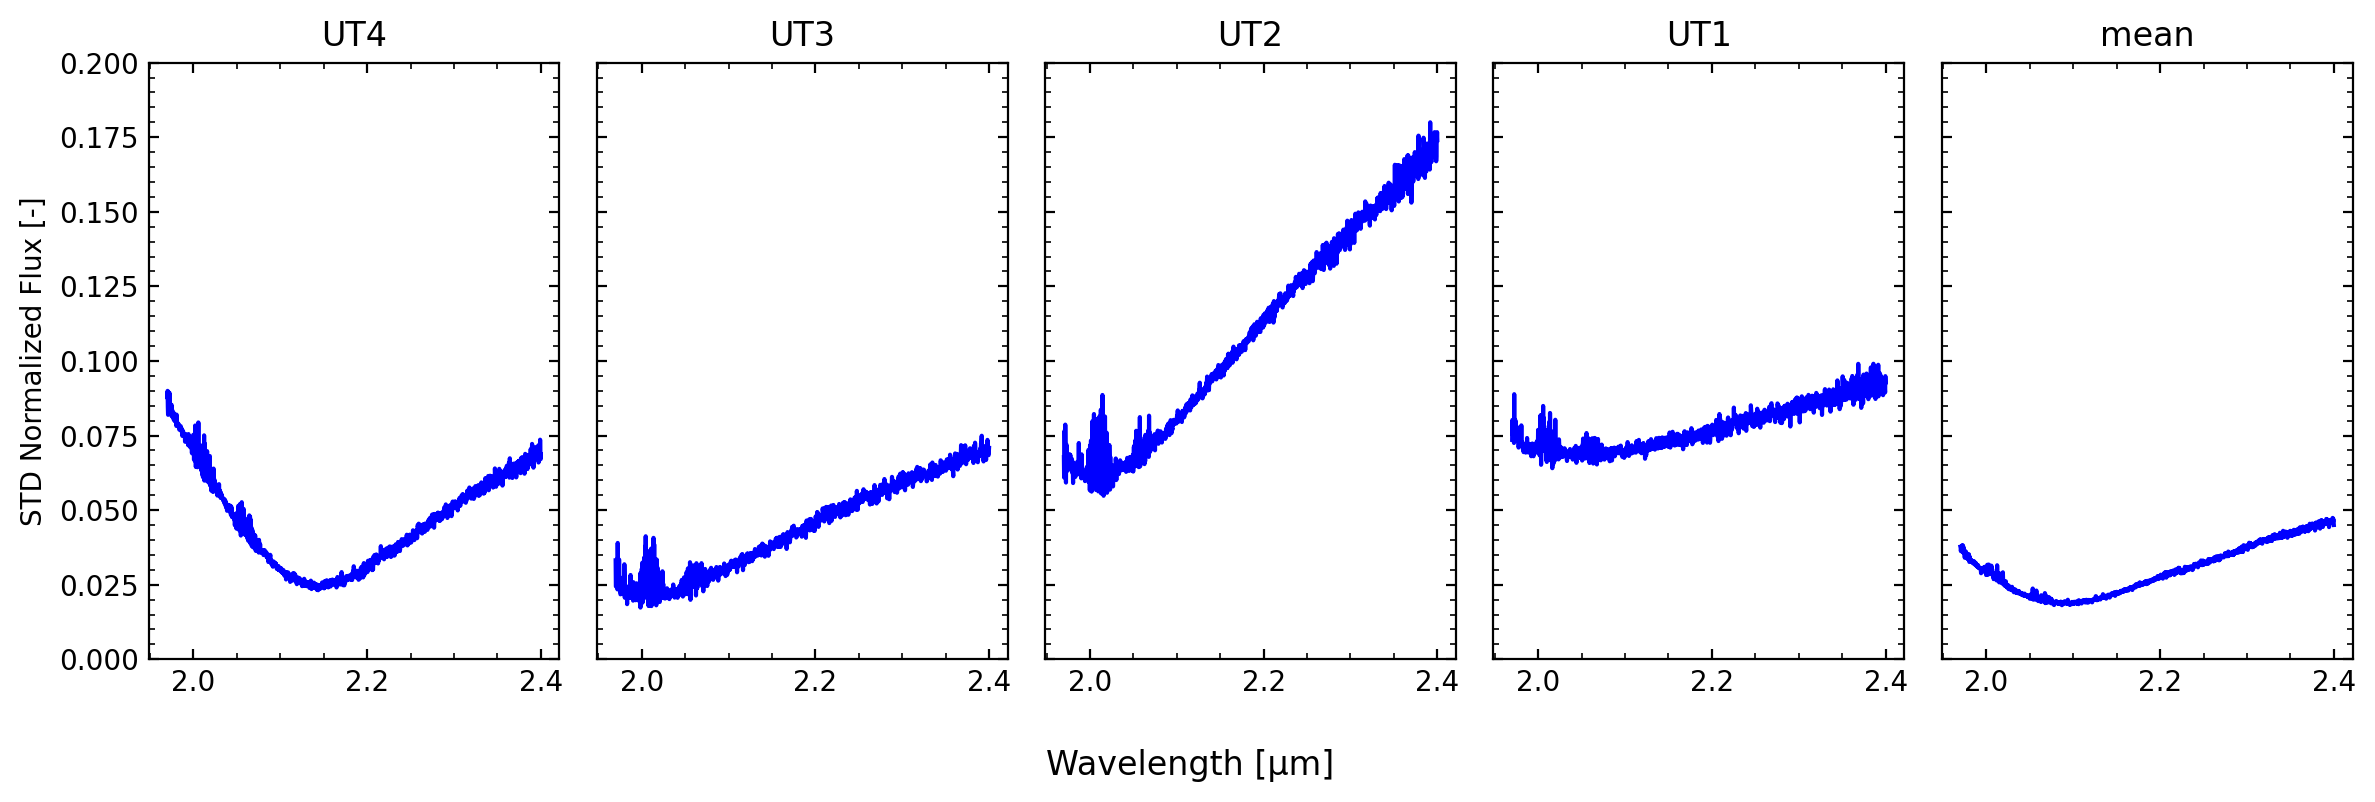

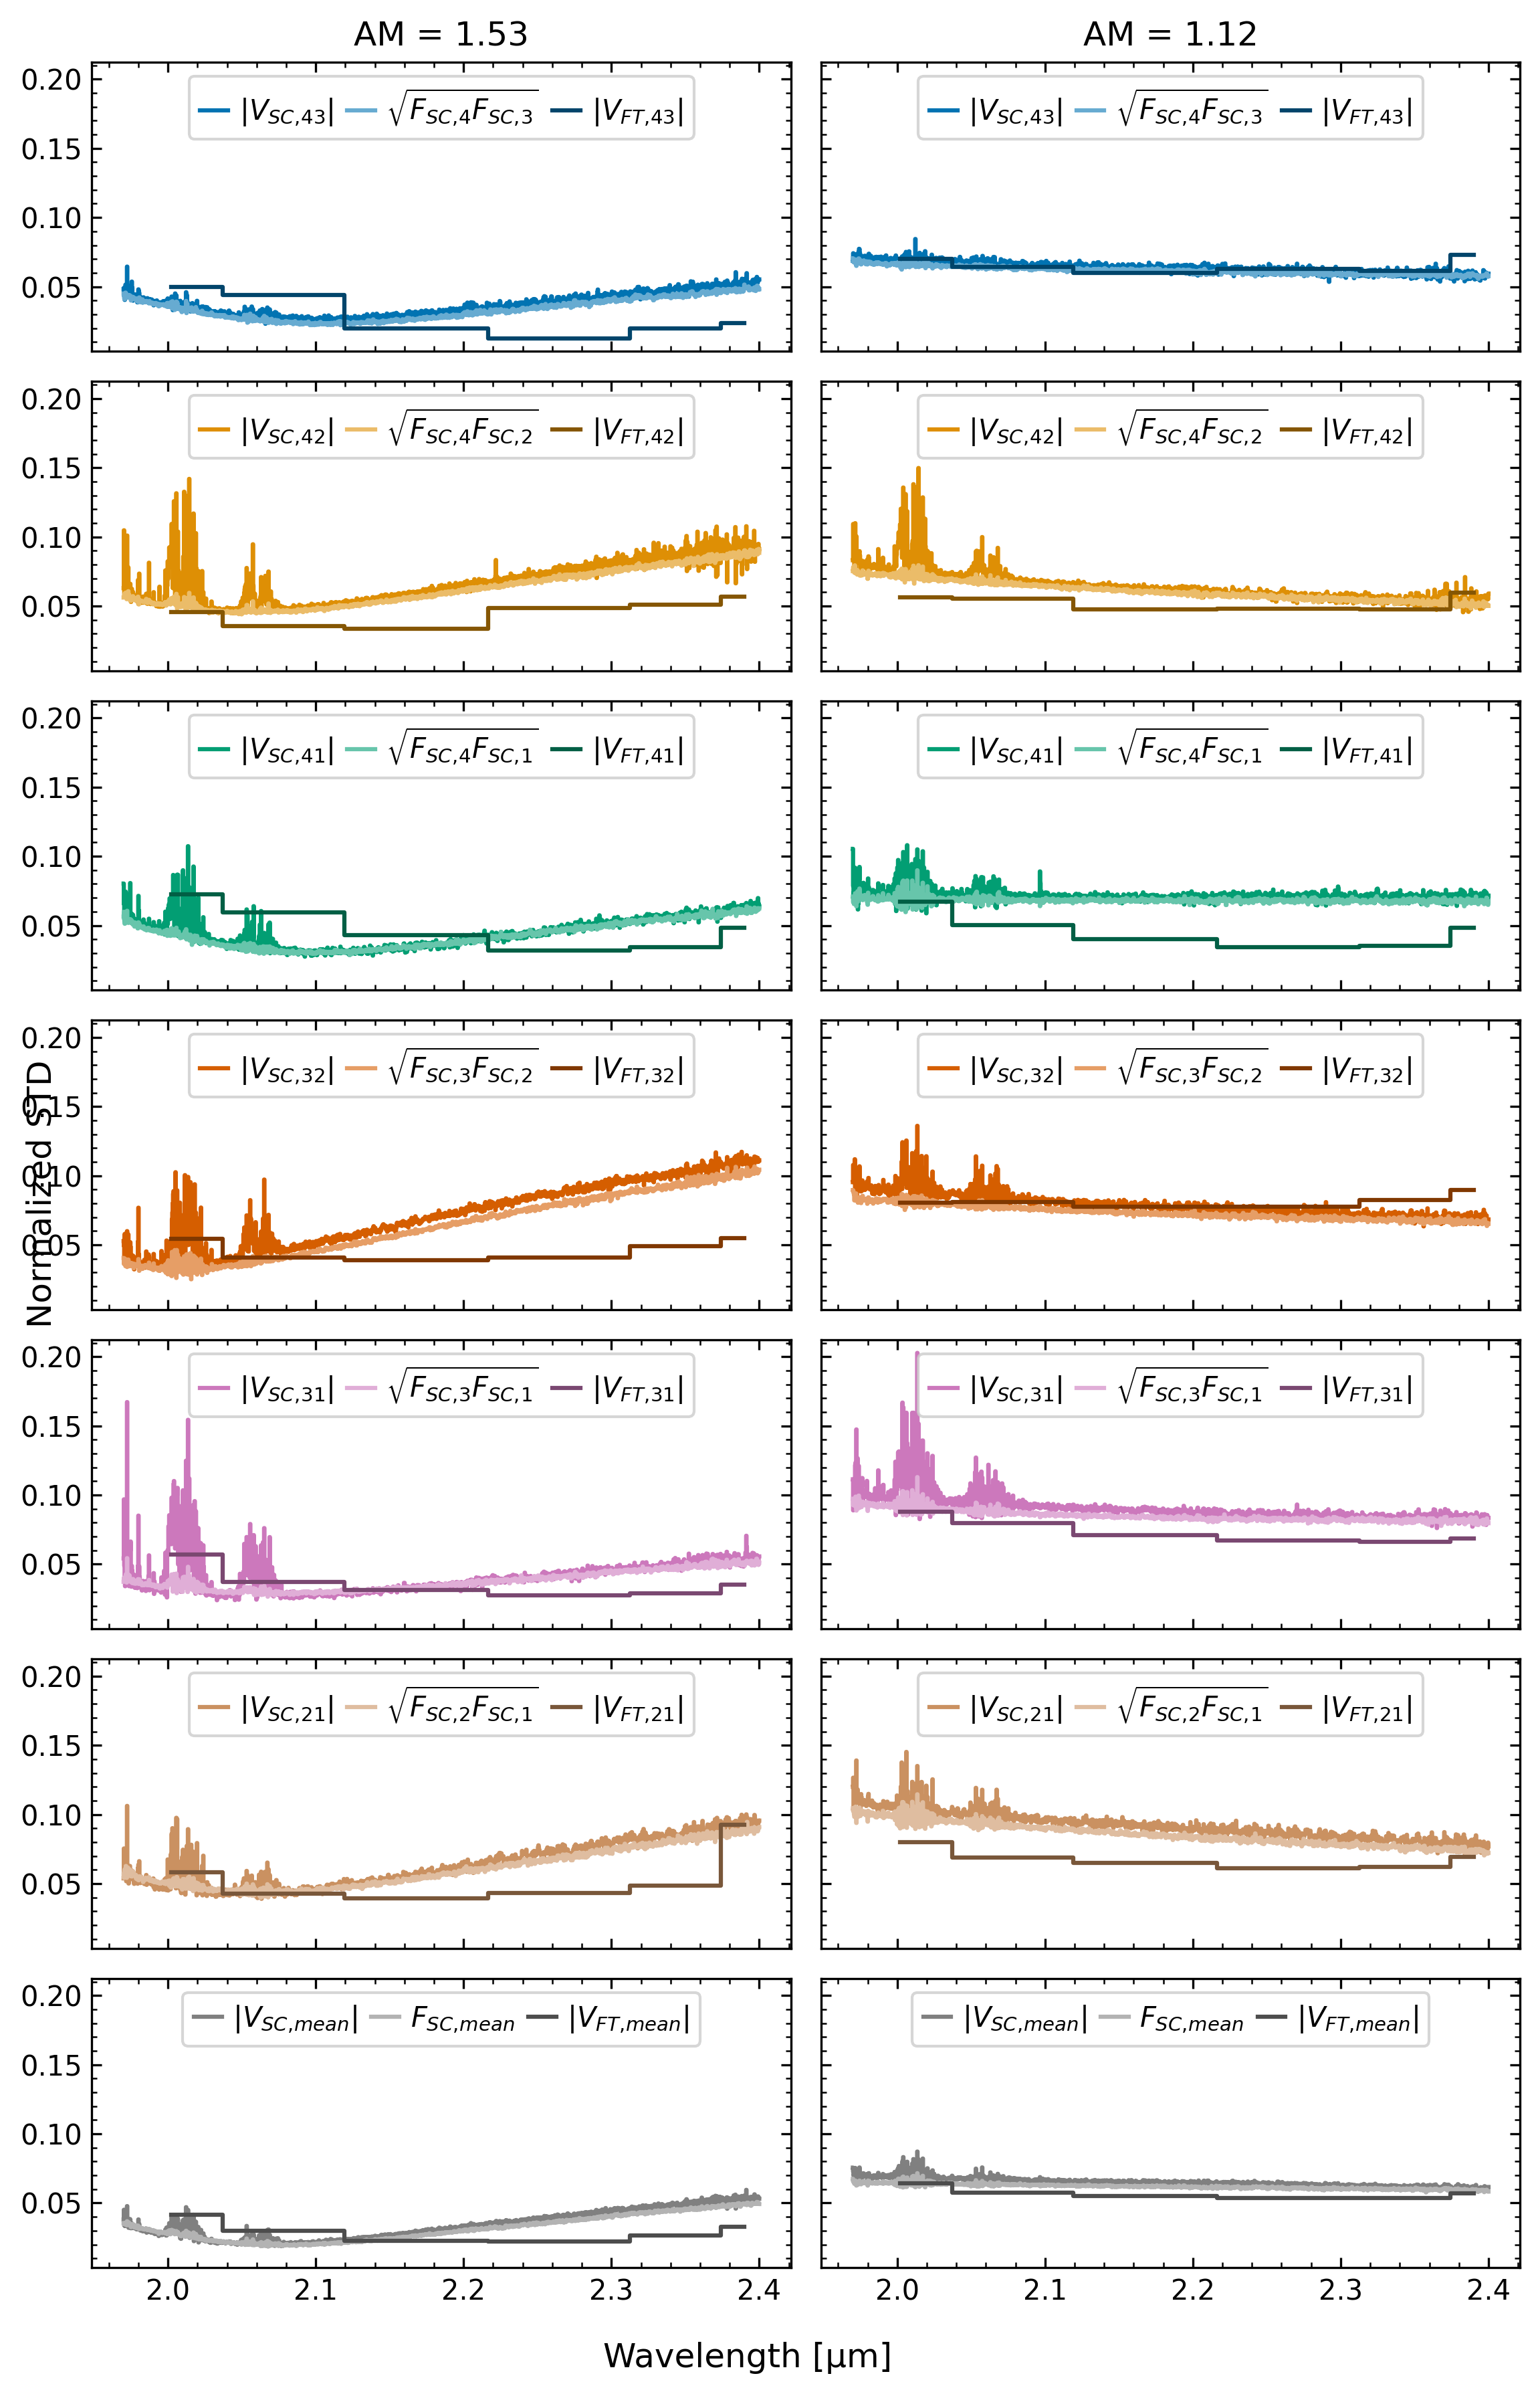

In [137]:
j = 0
print(AM[j])
fig,ax = plt.subplots(1,5,dpi=200,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.std(flux[j,:,i]/np.mean(flux[j,:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.std(np.mean(flux[j],axis=1)/np.mean(flux[j],axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('STD Normalized Flux [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.2])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

def adjust_color(color, factor):
    """Brighten (factor > 1) or darken (factor < 1) a color"""
    color = np.array(to_rgb(color))
    if factor > 1:
        return np.clip(color + (1 - color) * (factor - 1), 0, 1)
    else:
        return np.clip(color * factor, 0, 1)

col = sns.color_palette('colorblind')

bll = ["43","42","41","32","31","21"]
indi = [(4,3),(4,2),(4,1),(3,2),(3,1),(2,1)]

J = [0,9]

fig,ax = plt.subplots(7,2,dpi=300,figsize=(8,12),sharey=True,sharex=True)
for i in range(6):
    for j in range(2):
        #ax[i].set_title(bl_labels[i])

        base = col[i]
        light = adjust_color(base, 1.4)
        dark  = adjust_color(base, 0.6)

        ax[i][j].plot(wave*1e6,np.std(np.abs(vis[J[j]])[:,i]/np.mean(np.abs(vis[J[j]])[:,i],axis=0)[None,:],axis=0),color=base,ds='steps-mid',label=f'$|V_{{SC,\!{bll[i]}}}|$')
        ax[i][j].plot(wave*1e6,np.std(np.abs(vis_flux[J[j]])[:,i]/np.mean(np.abs(vis_flux[J[j]])[:,i],axis=0)[None,:],axis=0),color=light,ds='steps-mid',label = f'$\\sqrt{{F_{{SC,\!{indi[i][0]}}}F_{{SC,\!{indi[i][1]}}}}}$')
        ax[i][j].plot(wave_ft*1e6,np.std(np.abs(vis_ft[J[j]])[:,i]/np.mean(np.abs(vis_ft[J[j]])[:,i],axis=0)[None,:],axis=0),color=dark,ds='steps-mid',label=f'$|V_{{FT,\!{bll[i]}}}|$')
for j in range(2):
    base = 'gray'
    light = adjust_color(base, 1.4)
    dark  = adjust_color(base, 0.6)
    ax[6][j].plot(wave*1e6,np.std(np.mean(np.abs(vis[J[j]]),axis=1)/np.mean(np.abs(vis[J[j]]),axis=(0,1))[None,:],axis=0),color=base,label=f'$|V_{{SC,\!mean}}|$',ds='steps-mid')
    ax[6][j].plot(wave*1e6,np.std(np.mean(np.abs(vis_flux[J[j]]),axis=1)/np.mean(np.abs(vis_flux[J[j]]),axis=(0,1))[None,:],axis=0),color=light,label='$F_{SC,\!mean}$',ds='steps-mid')
    ax[6][j].plot(wave_ft*1e6,np.std(np.mean(np.abs(vis_ft[J[j]]),axis=1)/np.mean(np.abs(vis_ft[J[j]]),axis=(0,1))[None,:],axis=0),color=dark,ds='steps-mid',label=f'$|V_{{FT,\!mean}}|$')

    ax[0][j].set_title(f'AM = {AM[J[j]]:.2f}')
for i in range(7):
    for j in range(2):
        ax[i][j].legend(loc='upper center',fontsize=10,ncols=3,handlelength=1.0,handletextpad=0.4,columnspacing=0.5)
        ax[i][j].tick_params(axis='both', which='both', top=True, right=True, direction='in')
        ax[i][j].minorticks_on()
        
fig.supxlabel('Wavelength [µm]',y=0.01)
fig.subplots_adjust(bottom=0.05,top=0.96)
fig.supylabel('Normalized STD',x=0.05)
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/Normalized_STD_AM.pdf')
plt.tight_layout()
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


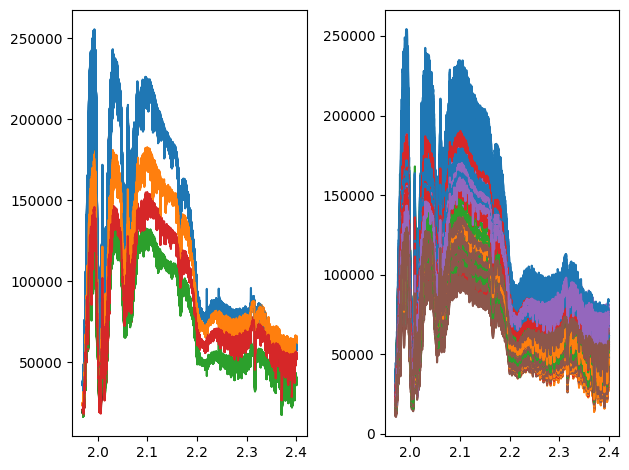

In [45]:
flux_cal = np.empty((18,16,4,1628))
vis_cal = np.empty((18,16,6,1628))
vis_flux_cal = np.empty((18,16,6,1628))

mflux = np.mean(flux,axis=(0,1))
mvis = np.mean(np.abs(vis),axis=(0,1))
mvis_ft = np.mean(np.abs(vis_ft),axis=(0,1))


for i in range(18):
    print(i)
    for j in range(16):
        F = []
        for k in range(4):
            f = flux[i,j,k]/mflux[k]
            z = np.polyfit(wave,f,2)
            p = np.poly1d(z)(wave)
            flux_cal[i,j,k] = flux[i,j,k]/p
            F.append(p)

        for k in range(6):
            #v = np.abs(vis[i,j,k])/mvis[k]
            #z = np.polyfit(wave,v,2)
            #p = np.poly1d(z)(wave)
            #p = np.sqrt(F[ind[k][0]]*F[ind[k][1]])
            v = np.abs(vis_ft[i,j,k])/mvis_ft[k]
            z = np.polyfit(wave_ft,v,2)
            p = np.poly1d(z)(wave)
            vis_cal[i,j,k] = np.abs(vis[i,j,k])/p

for i in range(6):
    t1 = ind[i][0]
    t2 = ind[i][1]
    vis_flux_cal[:,:,i] = np.sqrt(flux_cal[:,:,t1]*flux_cal[:,:,t2])


fig,ax = plt.subplots(1,2)
for i in range(18):
    for j in range(16):
        for k in range(4):
            ax[0].plot(wave*1e6,flux_cal[i,j,k],color=f'C{k}')
        for k in range(6):
            ax[1].plot(wave*1e6,vis_cal[i,j,k],color=f'C{k}')
plt.tight_layout()
plt.show()

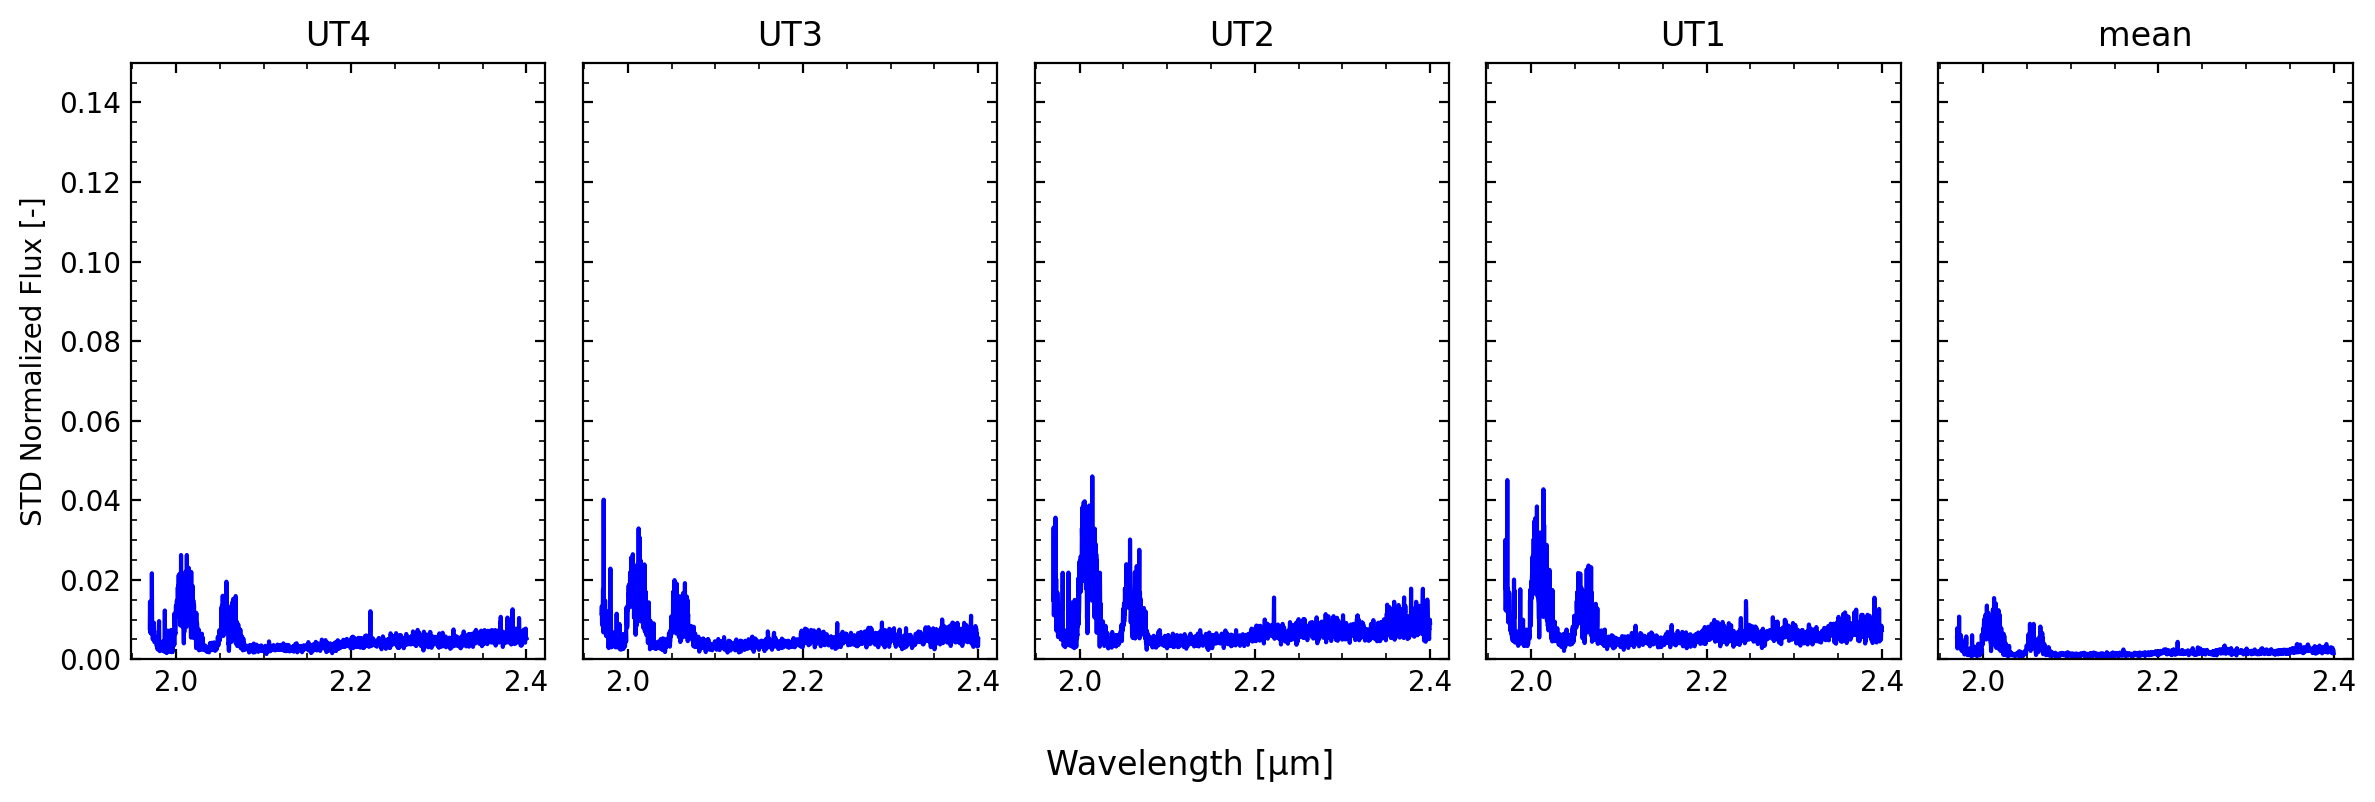

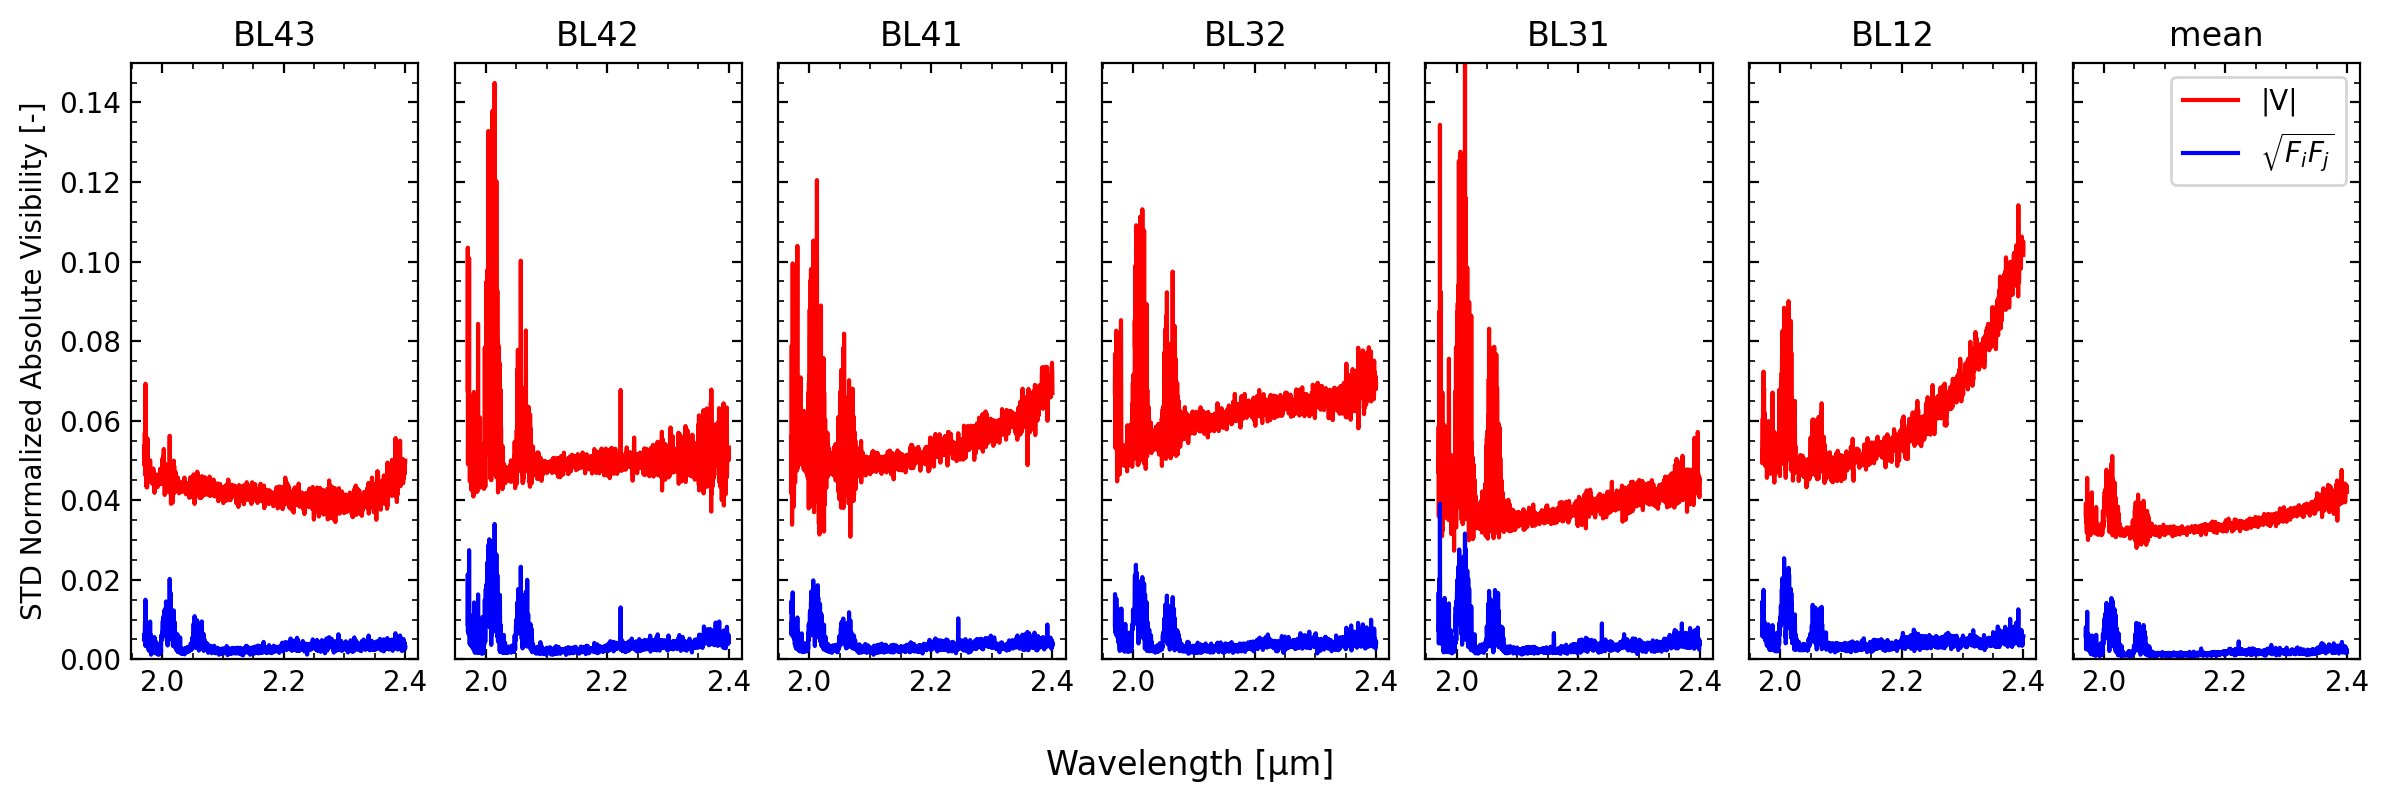

0.04209686763650824
0.003367096658768705
0.05124444770772635
0.004313721700559525
0.05487447471947374
0.0038410279170394087
0.06285004771776394
0.004360973281552122
0.04152645524643063
0.00409406578331805
0.06191946150877383
0.004679543066645936
0.034936935947129176
0.002195902003301619
median
0.04172556203409207
0.002972263687278088
0.04937306588718904
0.0032390285695242894
0.05319535347995247
0.0032879465589080517
0.06292764267675635
0.003620191096843758
0.03912104882874799
0.0031574993609609285
0.0558586158039822
0.004107424264718353
0.03388574997646999
0.0017390503658850991


In [46]:
j = 0

fig,ax = plt.subplots(1,5,dpi=200,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.std(flux_cal[j,:,i]/np.mean(flux_cal[j,:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.std(np.mean(flux_cal[j],axis=1)/np.mean(flux_cal[j],axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('STD Normalized Flux [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.15])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,7,dpi=200,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave*1e6,np.std(np.abs(vis_cal[j])[:,i]/np.mean(np.abs(vis_cal[j])[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave*1e6,np.std(np.abs(vis_flux_cal[j])[:,i]/np.mean(np.abs(vis_flux_cal[j])[:,i],axis=0)[None,:],axis=0),color='blue')
ax[6].plot(wave*1e6,np.std(np.mean(np.abs(vis_cal[j]),axis=1)/np.mean(np.abs(vis_cal[j]),axis=(0,1))[None,:],axis=0),color='red',label='|V|')
ax[6].plot(wave*1e6,np.std(np.mean(np.abs(vis_flux_cal[j]),axis=1)/np.mean(np.abs(vis_flux_cal[j]),axis=(0,1))[None,:],axis=0),color='blue',label='$\sqrt{F_iF_j}$')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('STD Normalized Absolute Visibility [-]')
ax[0].set_ylim([0.0,0.15])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

for i in range(6):
    print(np.mean(np.std(np.abs(vis_cal[j])[:,i]/np.mean(np.abs(vis_cal[j])[:,i],axis=0)[None,:],axis=0)))
    print(np.mean(np.std(np.abs(vis_flux_cal[j])[:,i]/np.mean(np.abs(vis_flux_cal[j])[:,i],axis=0)[None,:],axis=0)))
print(np.mean(np.std(np.mean(np.abs(vis_cal[j]),axis=1)/np.mean(np.abs(vis_cal[j]),axis=(0,1))[None,:],axis=0)))
print(np.mean(np.std(np.mean(np.abs(vis_flux_cal[j]),axis=1)/np.mean(np.abs(vis_flux_cal[j]),axis=(0,1))[None,:],axis=0)))

print('median')
for i in range(6):
    print(np.median(np.std(np.abs(vis_cal[j])[:,i]/np.mean(np.abs(vis_cal[j])[:,i],axis=0)[None,:],axis=0)))
    print(np.median(np.std(np.abs(vis_flux_cal[j])[:,i]/np.mean(np.abs(vis_flux_cal[j])[:,i],axis=0)[None,:],axis=0)))
print(np.median(np.std(np.mean(np.abs(vis_cal[j]),axis=1)/np.mean(np.abs(vis_cal[j]),axis=(0,1))[None,:],axis=0)))
print(np.median(np.std(np.mean(np.abs(vis_flux_cal[j]),axis=1)/np.mean(np.abs(vis_flux_cal[j]),axis=(0,1))[None,:],axis=0)))

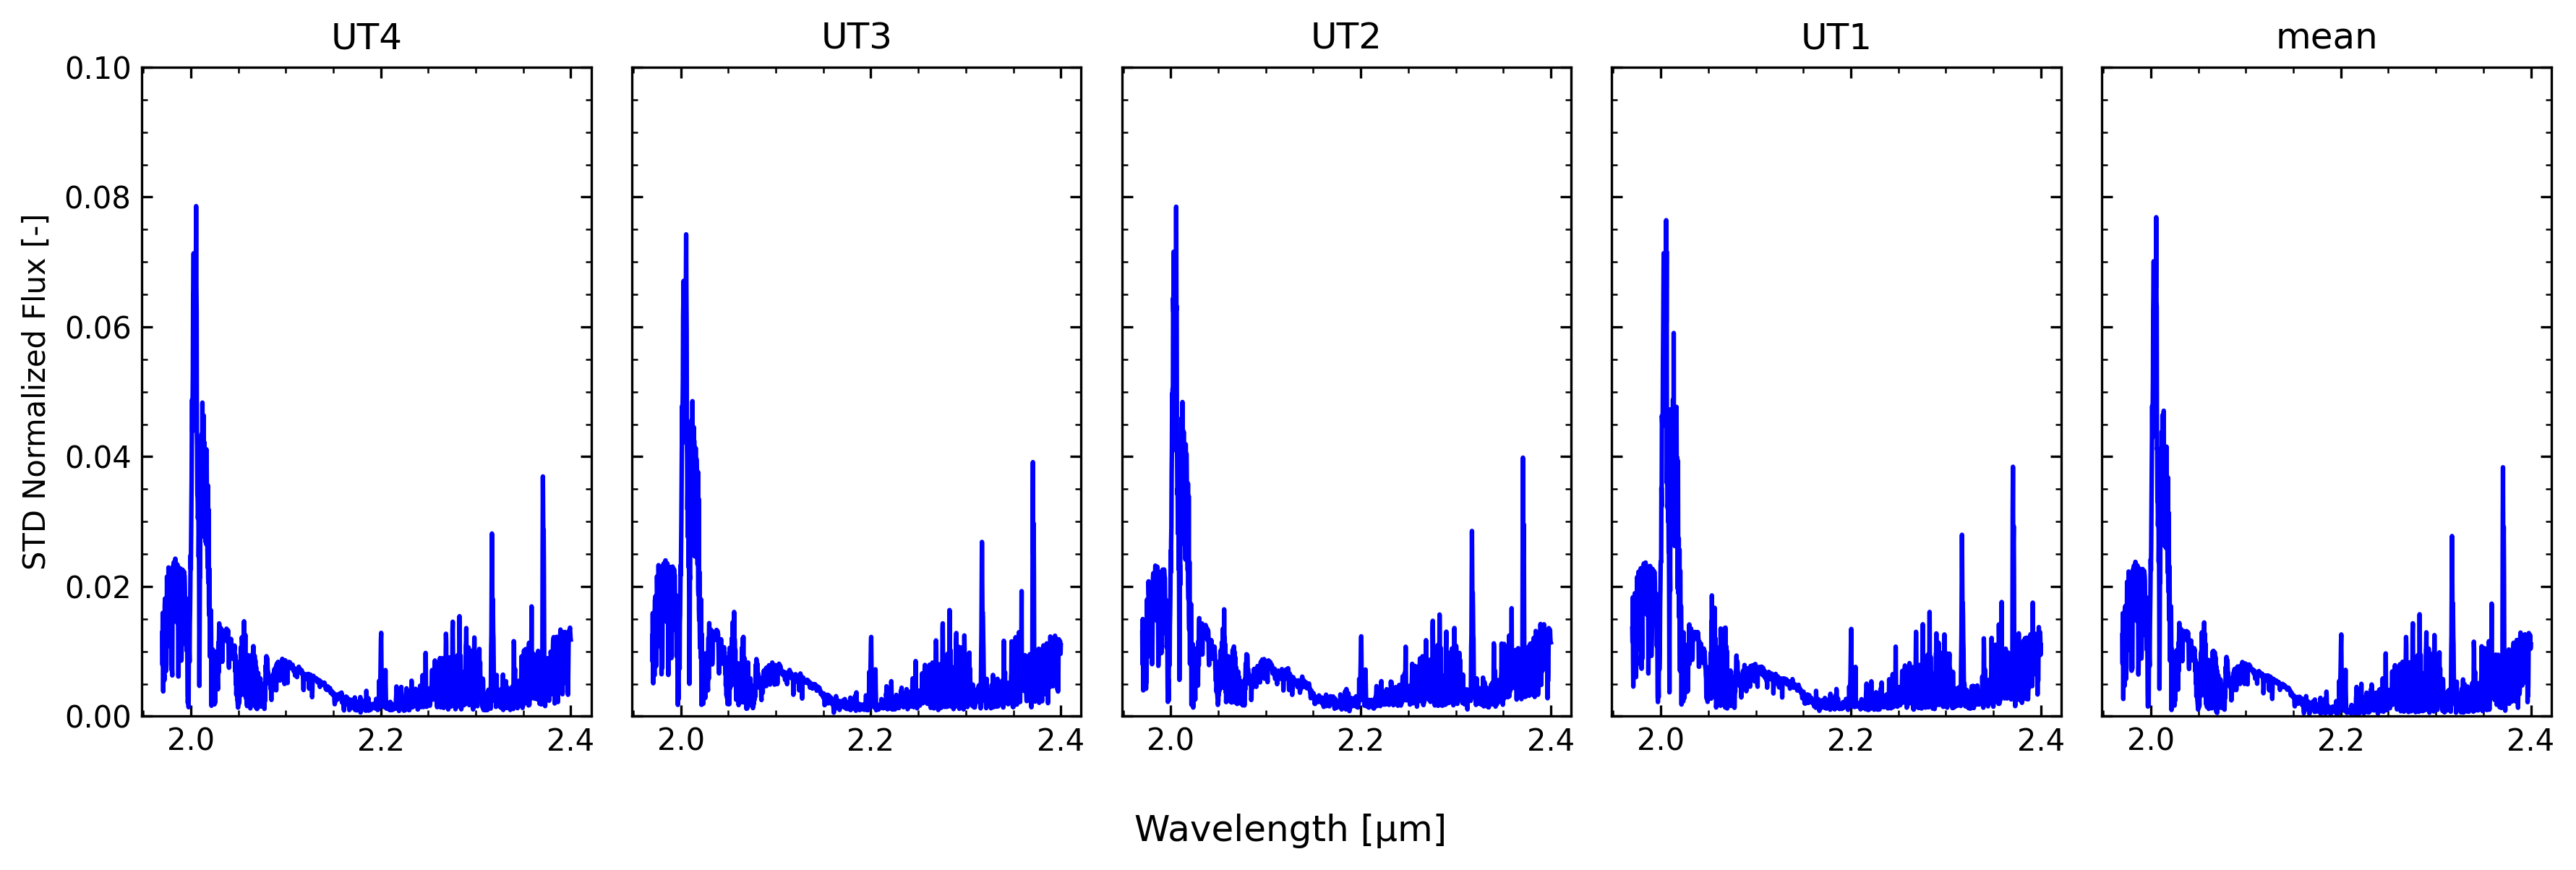

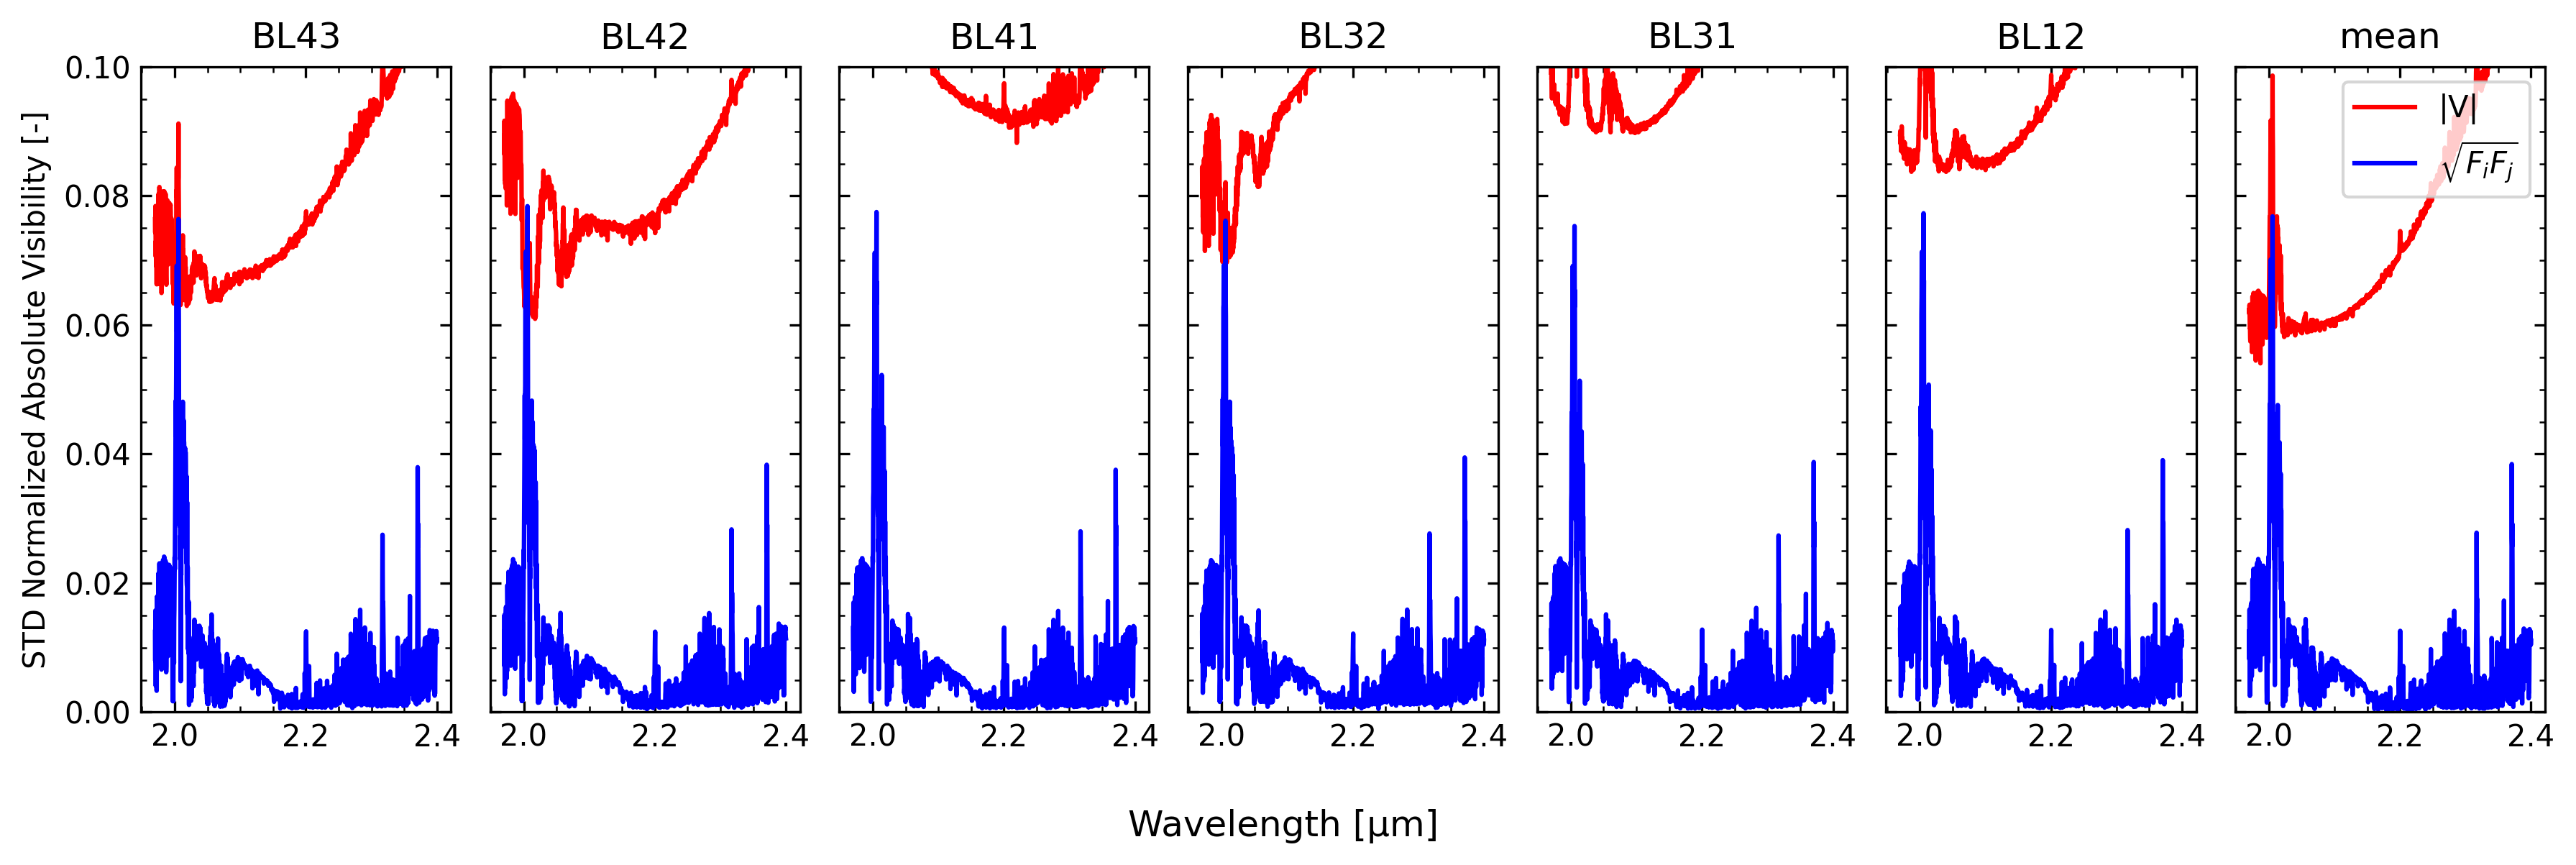

vis_0: 0.0804820896888613
vis_flux_0: 0.007176272831075715
vis_1: 0.08391767773662845
vis_flux_1: 0.007264440716690409
vis_2: 0.10156942146216463
vis_flux_2: 0.0071774389483420555
vis_3: 0.11157452563095166
vis_flux_3: 0.00718534560693749
vis_4: 0.10892433453756788
vis_flux_4: 0.00708419545071587
vis_5: 0.10240474340880662
vis_flux_5: 0.007181176139526442
vis_mean: 0.07727755591991542
vis_flux_mean: 0.007038530364987119
vis_0: 0.0761895040054189
vis_flux_0: 0.004461144729958601
vis_1: 0.07974141206059163
vis_flux_1: 0.004599386273224778
vis_2: 0.0977327127095656
vis_flux_2: 0.0045456403517751785
vis_3: 0.10694628519531399
vis_flux_3: 0.0046138613451355386
vis_4: 0.10248998853971297
vis_flux_4: 0.004509519947223694
vis_5: 0.09594543397871147
vis_flux_5: 0.004623087789210594
vis_mean: 0.07009072811852674
vis_flux_mean: 0.004455638084275335


In [47]:
labels = ['UT4','UT3','UT2','UT1']

fig,ax = plt.subplots(1,5,dpi=300,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.std(np.mean(flux_cal,axis=1)[:,i]/np.mean(np.mean(flux_cal,axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.std(np.mean(np.mean(flux_cal,axis=1),axis=1)/np.mean(np.mean(flux_cal,axis=1),axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('STD Normalized Flux [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.1])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

bl_labels = ["BL43","BL42","BL41","BL32","BL31","BL12"]

fig,ax = plt.subplots(1,7,dpi=300,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave*1e6,np.std(np.mean(np.abs(vis_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave*1e6,np.std(np.mean(np.abs(vis_flux_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_flux_cal),axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
ax[6].plot(wave*1e6,np.std(np.mean(np.mean(np.abs(vis_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0),color='red',label='|V|')
ax[6].plot(wave*1e6,np.std(np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=(0,1))[None,:],axis=0),color='blue',label='$\sqrt{F_iF_j}$')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('STD Normalized Absolute Visibility [-]')
ax[0].set_ylim([0.0,0.1])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

for i in range(6):
    print(f'vis_{i}:',np.mean(np.std(np.mean(np.abs(vis_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0)))
    print(f'vis_flux_{i}:',np.mean(np.std(np.mean(np.abs(vis_flux_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_flux_cal),axis=1)[:,i],axis=0)[None,:],axis=0)))
print('vis_mean:',np.mean(np.std(np.mean(np.mean(np.abs(vis_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0)))
print('vis_flux_mean:',np.mean(np.std(np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=(0,1))[None,:],axis=0)))

for i in range(6):
    print(f'vis_{i}:',np.median(np.std(np.mean(np.abs(vis_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0)))
    print(f'vis_flux_{i}:',np.median(np.std(np.mean(np.abs(vis_flux_cal),axis=1)[:,i]/np.mean(np.mean(np.abs(vis_flux_cal),axis=1)[:,i],axis=0)[None,:],axis=0)))
print('vis_mean:',np.median(np.std(np.mean(np.mean(np.abs(vis_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0)))
print('vis_flux_mean:',np.median(np.std(np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=1)/np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=(0,1))[None,:],axis=0)))

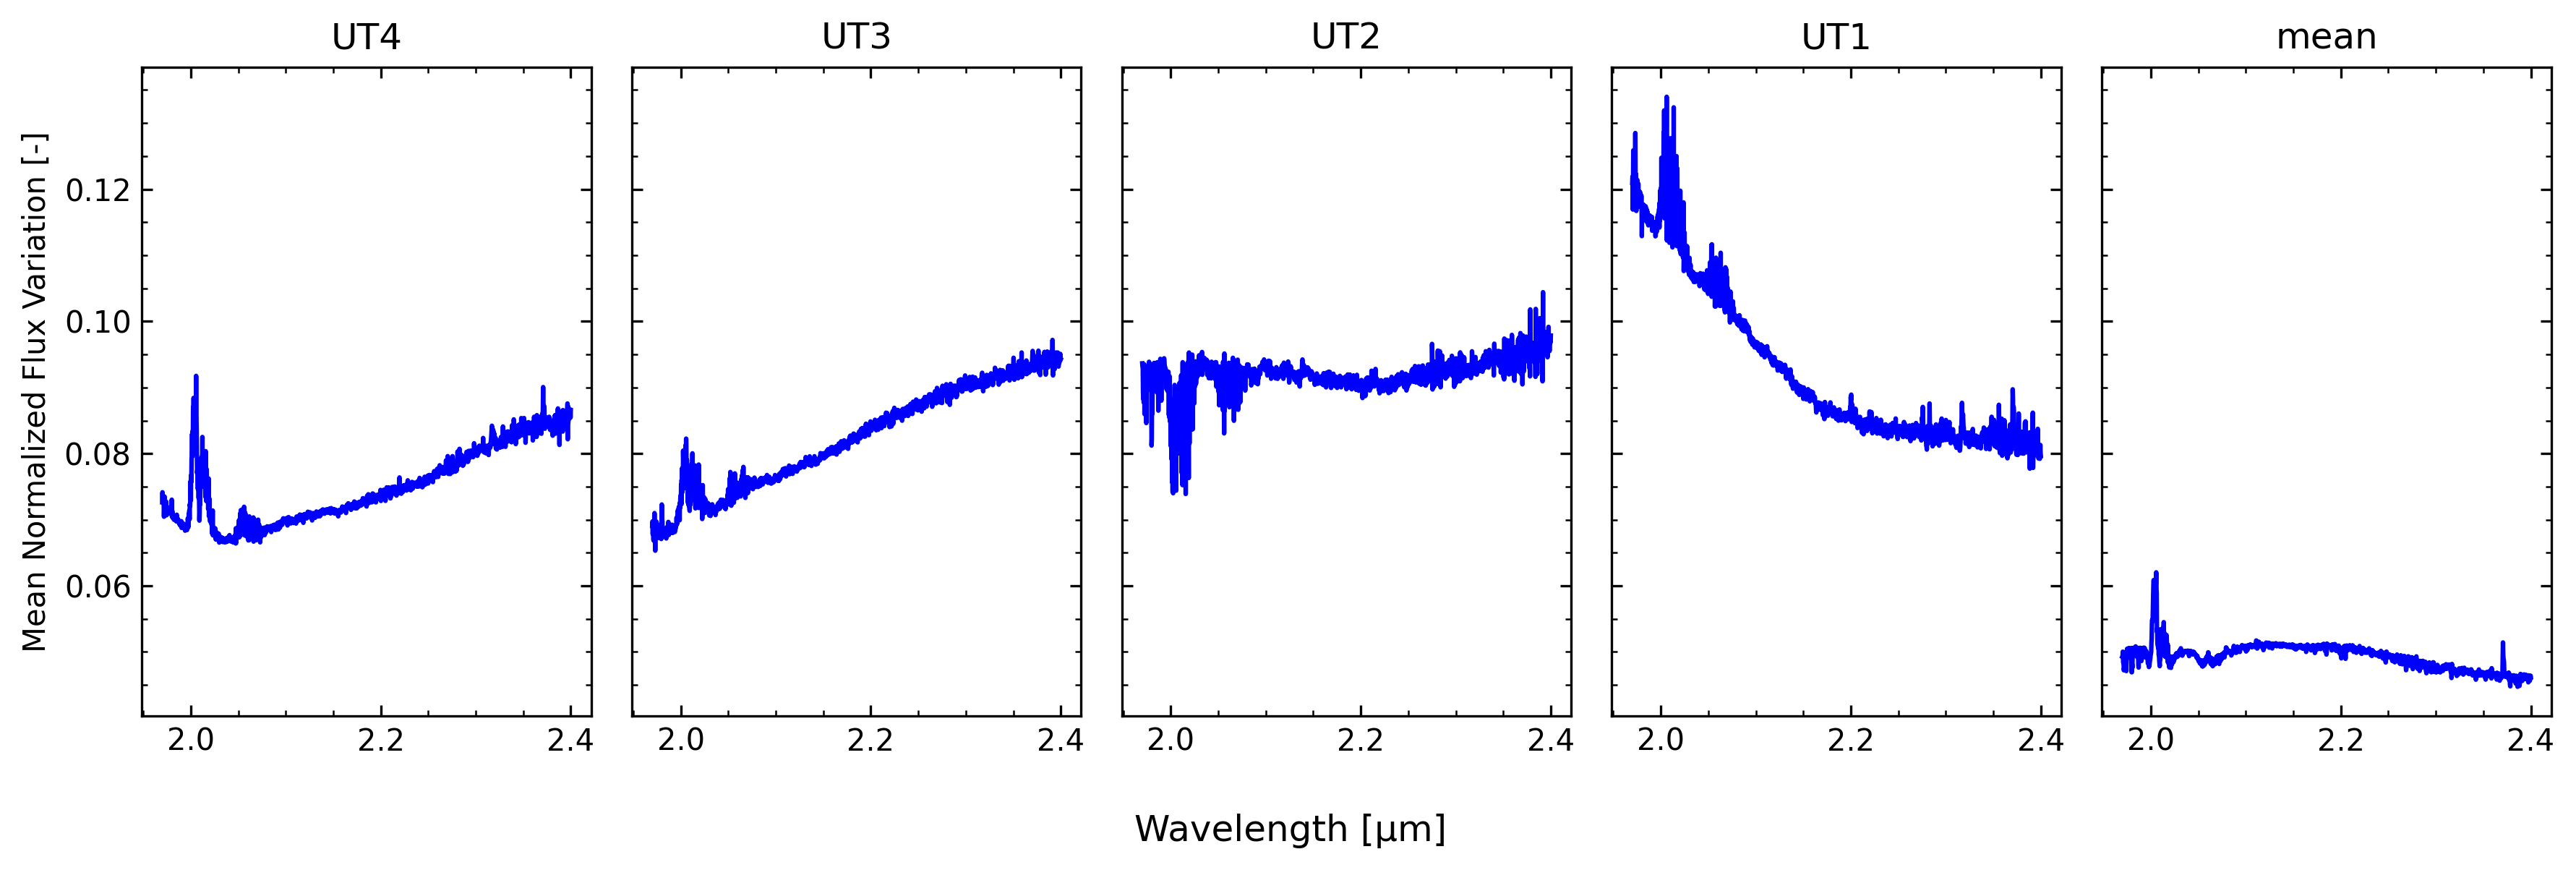

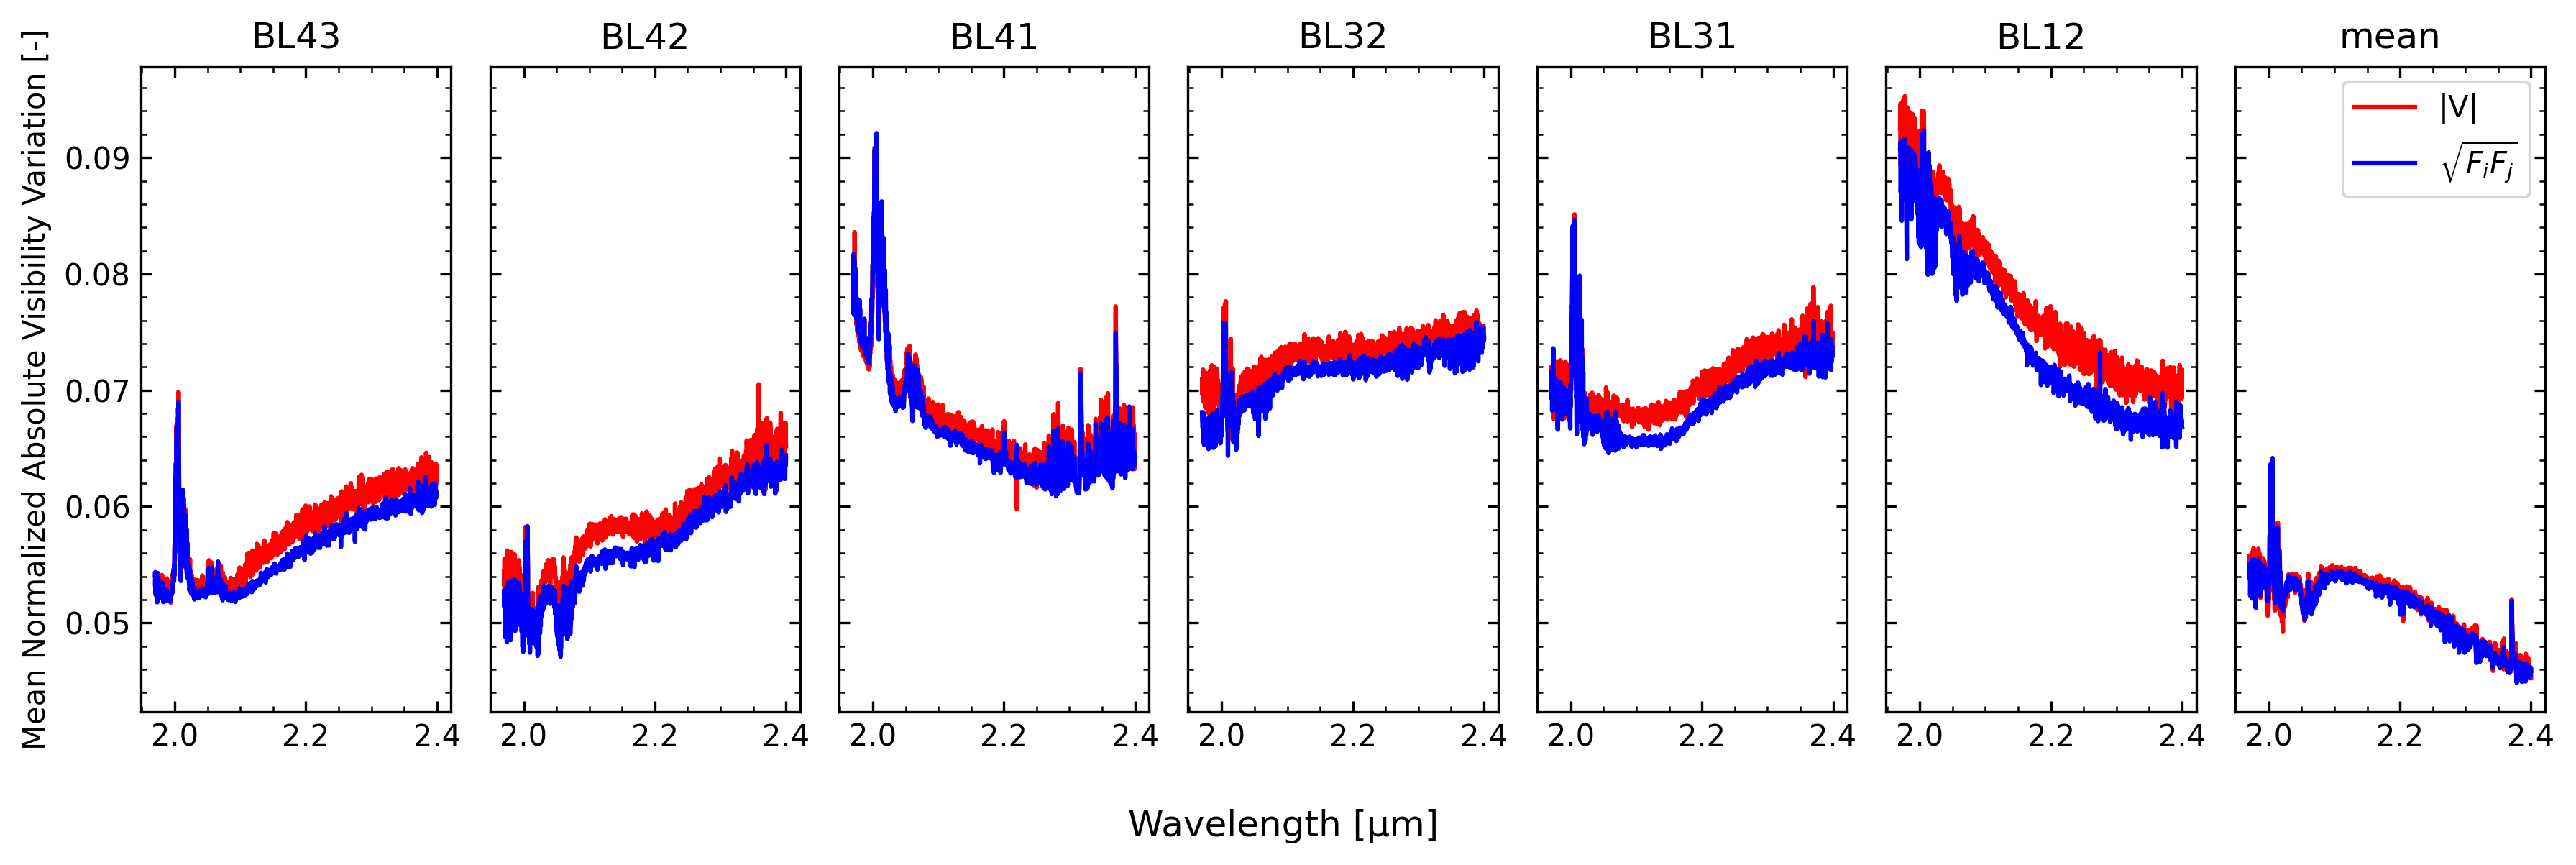

0.05804412117009597 + 0.0032993098962697254 - 0.004649937547821094
0.056478691989779194 + 0.003458899122104127 - 0.003818438457128849
0.05814324993326572 + 0.004767609387049149 - 0.003946061491121089
0.056299802431190094 + 0.005337552615133689 - 0.003998551399004478
0.06576350433415329 + 0.005089523175574331 - 0.0022861879229903043
0.06485941766926154 + 0.005637753155258288 - 0.0020665584830942413
0.07275484377268181 + 0.0011172825381392804 - 0.0023083678578998817
0.07190865319787734 + 0.0014381726333849154 - 0.0029634683829220937
0.07033008941711327 + 0.002859201510489226 - 0.0027326474346329316
0.06913301497096636 + 0.003330802986244996 - 0.0033072236344854067
0.0752550001790289 + 0.01061242077846021 - 0.005043707581950968
0.07212246061792121 + 0.010901178587576915 - 0.004621361204636437
0.05203244695132375 + 0.0019464335050922363 - 0.004612939784594226
0.05216329642662271 + 0.0017856063093004276 - 0.00468025962718794


In [48]:
labels = ['UT4','UT3','UT2','UT1']

fig,ax = plt.subplots(1,5,dpi=300,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(flux,axis=1)[1:,i]-np.mean(flux,axis=1)[:-1,i])/np.mean(np.mean(flux,axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(flux[1:],axis=1),axis=1)-np.mean(np.mean(flux[:-1],axis=1),axis=1))/np.mean(np.mean(flux,axis=1),axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('Mean Normalized Flux Variation [-]')
ax[4].set_title('mean')
#ax[0].set_ylim([0.0,0.035])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

bl_labels = ["BL43","BL42","BL41","BL32","BL31","BL12"]

fig,ax = plt.subplots(1,7,dpi=300,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(np.abs(vis[1:]),axis=1)[:,i]-np.mean(np.abs(vis[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis),axis=1)[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(np.abs(vis_flux[1:]),axis=1)[:,i]-np.mean(np.abs(vis_flux[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_flux),axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
ax[6].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(np.abs(vis[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis),axis=1),axis=(0,1))[None,:],axis=0),color='red',label='|V|')
ax[6].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(np.abs(vis_flux[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_flux[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_flux),axis=1),axis=(0,1))[None,:],axis=0),color='blue',label='$\sqrt{F_iF_j}$')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('Mean Normalized Absolute Visibility Variation [-]')
#ax[0].set_ylim([0.0,0.035])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

for i in range(6):
    a = np.mean(np.abs(np.mean(np.abs(vis[1:]),axis=1)[:,i]-np.mean(np.abs(vis[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0)
    b = np.mean(np.abs(np.mean(np.abs(vis_flux[1:]),axis=1)[:,i]-np.mean(np.abs(vis_flux[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_flux),axis=1)[:,i],axis=0)[None,:],axis=0)
    print(np.percentile(a,50),'+',np.percentile(a,84)-np.percentile(a,50),'-',np.percentile(a,50)-np.percentile(a,16))
    print(np.percentile(b,50),'+',np.percentile(b,84)-np.percentile(b,50),'-',np.percentile(b,50)-np.percentile(b,16))
a = np.mean(np.abs(np.mean(np.mean(np.abs(vis[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0)
b = np.mean(np.abs(np.mean(np.mean(np.abs(vis_flux[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_flux[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_flux),axis=1),axis=(0,1))[None,:],axis=0)
print(np.percentile(a,50),'+',np.percentile(a,84)-np.percentile(a,50),'-',np.percentile(a,50)-np.percentile(a,16))
print(np.percentile(b,50),'+',np.percentile(b,84)-np.percentile(b,50),'-',np.percentile(b,50)-np.percentile(b,16))

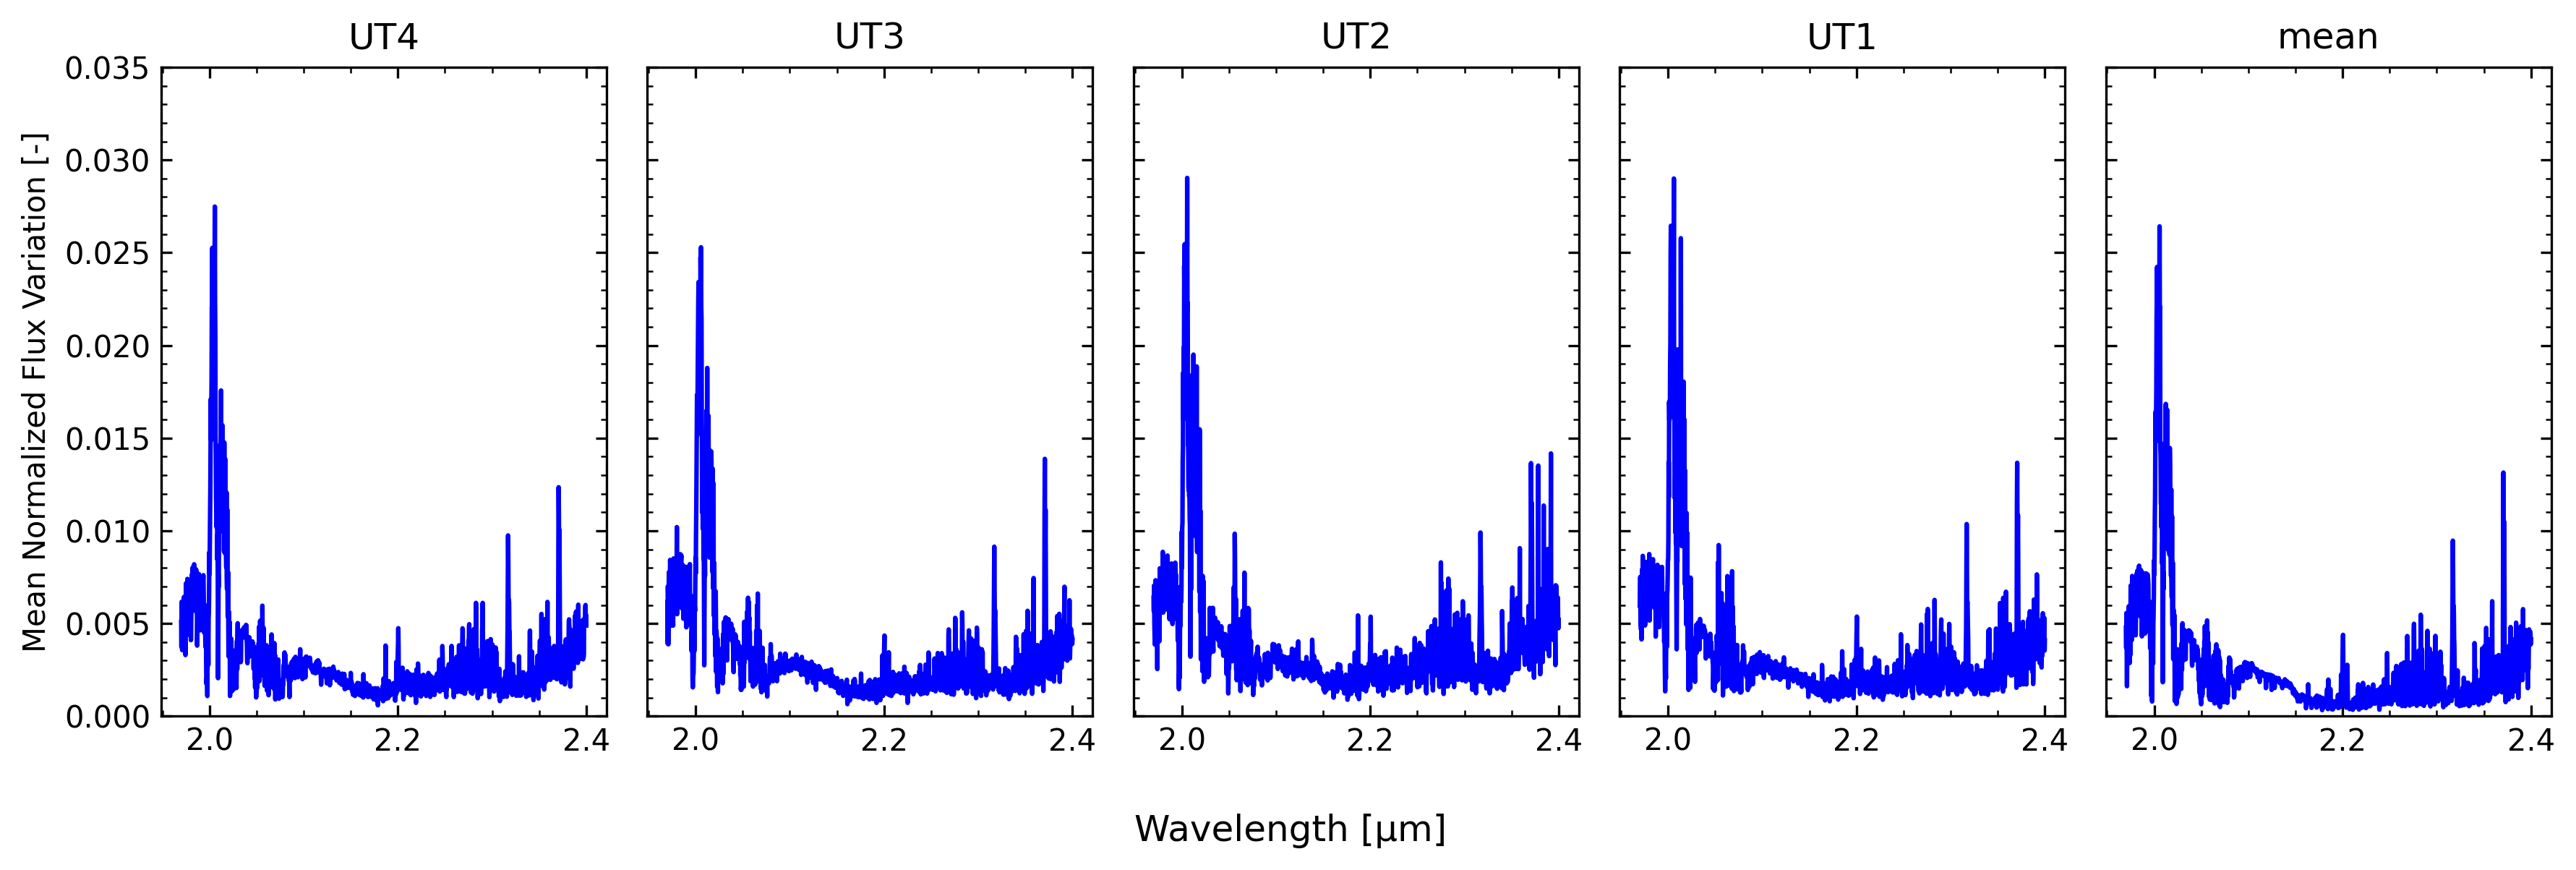

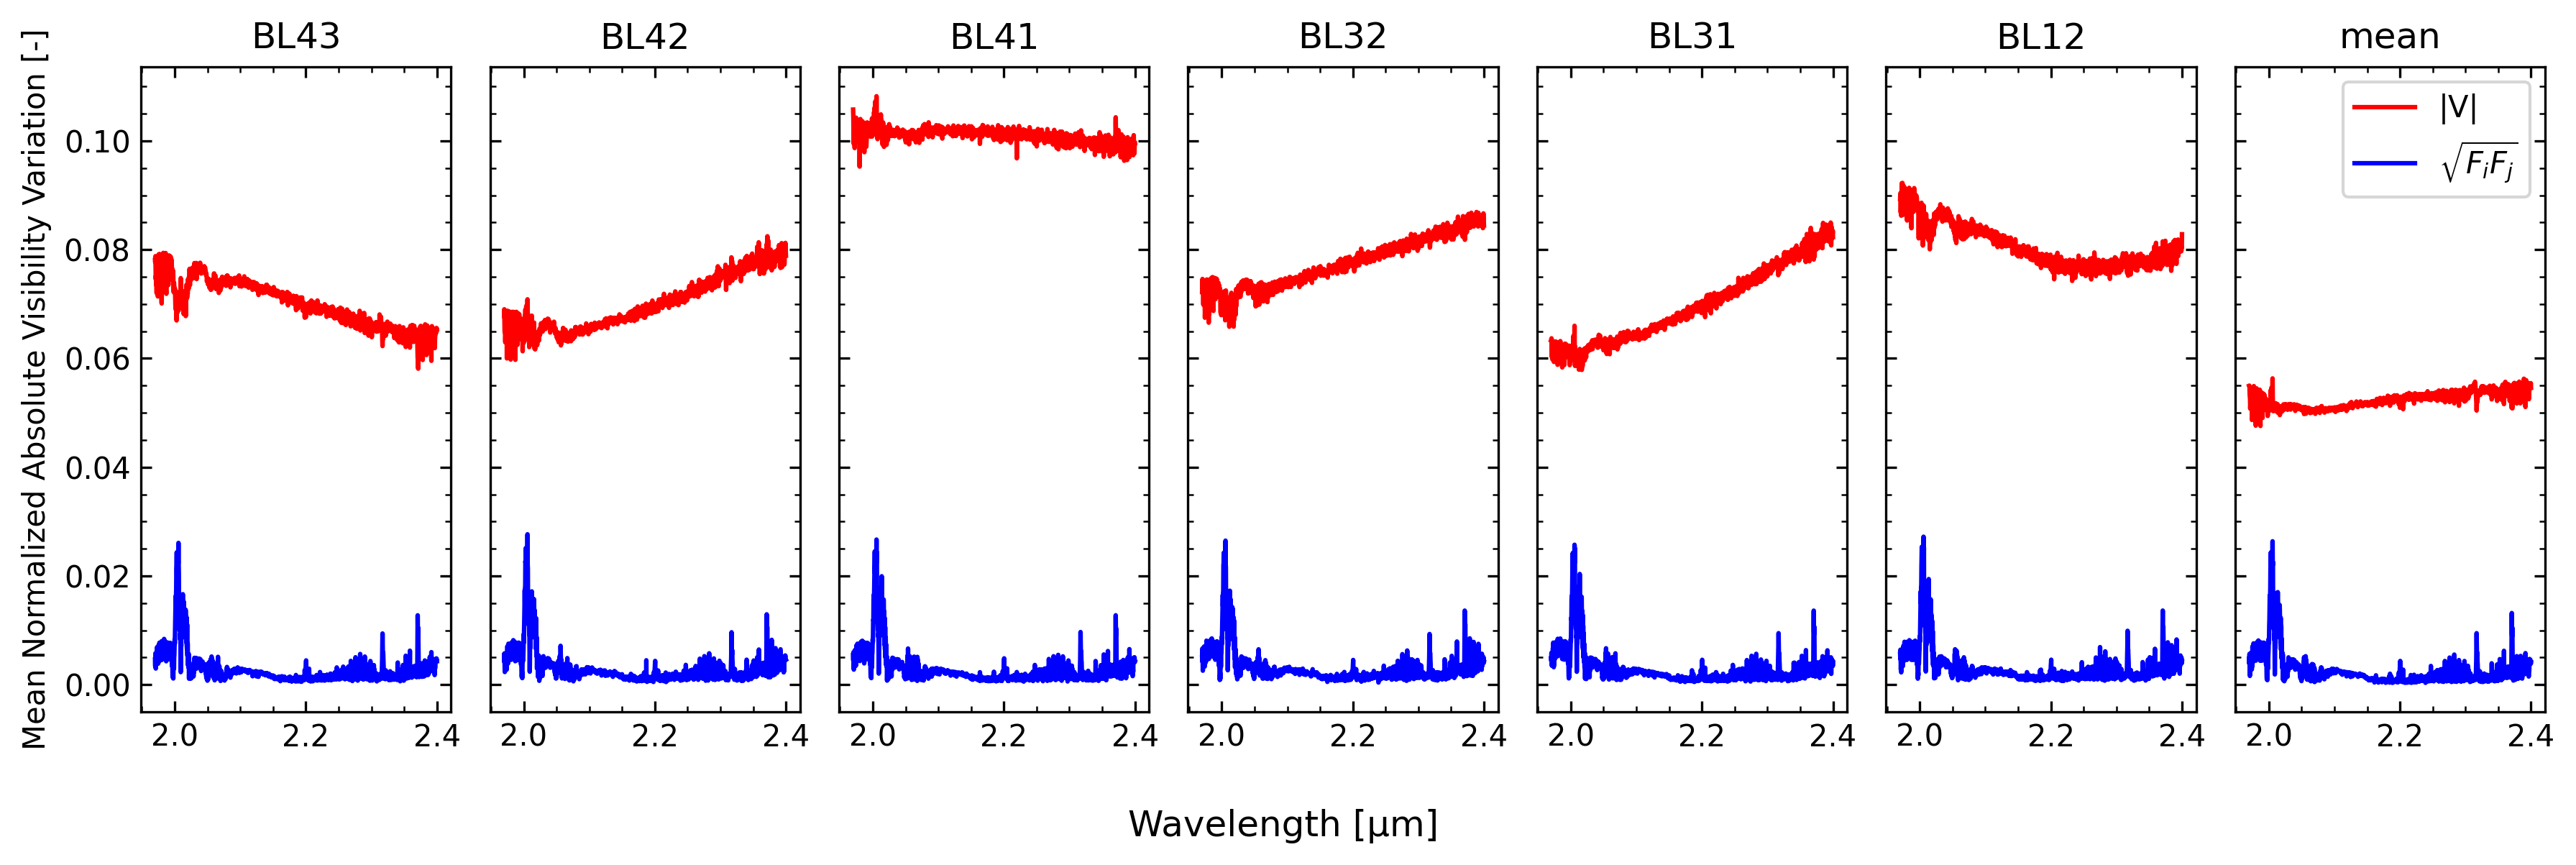

0.0702536928250534 + 0.004192054727758993 - 0.0048066247362383435
0.00196340876560761 + 0.002254482783182977 - 0.0008642947307326003
0.06885280608971066 + 0.007592764436391827 - 0.0036071216263917905
0.0021244863765890144 + 0.002313342902043855 - 0.0009363545517995745
0.10119609531383972 + 0.0008965497373821796 - 0.001466343422725877
0.001966998136529092 + 0.00228796651421096 - 0.0008764286110204327
0.07708670030303479 + 0.0056728934084478155 - 0.004314544523027014
0.0021404374925279275 + 0.002301752279259252 - 0.0008270675589013515
0.06877865055649486 + 0.009531440595578297 - 0.006310243981683825
0.0019368715039069567 + 0.002368944120383987 - 0.0008702125880733452
0.07941468727709504 + 0.005304331873961621 - 0.002466704403223441
0.0021149872307654263 + 0.0024230226527515632 - 0.000833654516099726
0.05251072479435557 + 0.0015717220571292434 - 0.001697382374785221
0.0017582729842024825 + 0.002268689426641847 - 0.0009655923606657357


In [50]:
labels = ['UT4','UT3','UT2','UT1']

fig,ax = plt.subplots(1,5,dpi=300,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(flux_cal,axis=1)[1:,i]-np.mean(flux_cal,axis=1)[:-1,i])/np.mean(np.mean(flux_cal,axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(flux_cal[1:],axis=1),axis=1)-np.mean(np.mean(flux_cal[:-1],axis=1),axis=1))/np.mean(np.mean(flux_cal,axis=1),axis=(0,1))[None,:],axis=0),color='blue')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('Mean Normalized Flux Variation [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.035])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

bl_labels = ["BL43","BL42","BL41","BL32","BL31","BL12"]

fig,ax = plt.subplots(1,7,dpi=300,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(np.abs(vis_cal[1:]),axis=1)[:,i]-np.mean(np.abs(vis_cal[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave*1e6,np.mean(np.abs(np.mean(np.abs(vis_flux_cal[1:]),axis=1)[:,i]-np.mean(np.abs(vis_flux_cal[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_flux_cal),axis=1)[:,i],axis=0)[None,:],axis=0),color='blue')
ax[6].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(np.abs(vis_cal[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_cal[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0),color='red',label='|V|')
ax[6].plot(wave*1e6,np.mean(np.abs(np.mean(np.mean(np.abs(vis_flux_cal[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_flux_cal[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=(0,1))[None,:],axis=0),color='blue',label='$\sqrt{F_iF_j}$')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('Mean Normalized Absolute Visibility Variation [-]')
#ax[0].set_ylim([0.0,0.035])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

for i in range(6):
    a = np.mean(np.abs(np.mean(np.abs(vis_cal[1:]),axis=1)[:,i]-np.mean(np.abs(vis_cal[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_cal),axis=1)[:,i],axis=0)[None,:],axis=0)
    b = np.mean(np.abs(np.mean(np.abs(vis_flux_cal[1:]),axis=1)[:,i]-np.mean(np.abs(vis_flux_cal[:-1]),axis=1)[:,i])/np.mean(np.mean(np.abs(vis_flux_cal),axis=1)[:,i],axis=0)[None,:],axis=0)
    print(np.percentile(a,50),'+',np.percentile(a,84)-np.percentile(a,50),'-',np.percentile(a,50)-np.percentile(a,16))
    print(np.percentile(b,50),'+',np.percentile(b,84)-np.percentile(b,50),'-',np.percentile(b,50)-np.percentile(b,16))
a = np.mean(np.abs(np.mean(np.mean(np.abs(vis_cal[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_cal[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_cal),axis=1),axis=(0,1))[None,:],axis=0)
b = np.mean(np.abs(np.mean(np.mean(np.abs(vis_flux_cal[1:]),axis=1),axis=1)-np.mean(np.mean(np.abs(vis_flux_cal[:-1]),axis=1),axis=1))/np.mean(np.mean(np.abs(vis_flux_cal),axis=1),axis=(0,1))[None,:],axis=0)
print(np.percentile(a,50),'+',np.percentile(a,84)-np.percentile(a,50),'-',np.percentile(a,50)-np.percentile(a,16))
print(np.percentile(b,50),'+',np.percentile(b,84)-np.percentile(b,50),'-',np.percentile(b,50)-np.percentile(b,16))

In [7]:
k = 0

for i in range(16):
    fig,ax = plt.subplots(2,2,dpi=200,sharex=True)
    for j in range(4):
        ax[0][0].plot(wave*1e6,flux[k,i,j,:],color=f'C{j}',label=labels[j])
        f = flux[k,i,j,:]/np.mean(flux[k,:,j,:],axis=0)
        z = np.polyfit(wave,f,2)
        p = np.poly1d(z)(wave)
        ax[1][0].plot(wave*1e6,f,color=f'C{j}')
        ax[1][0].plot(wave*1e6,p,':',color='white')
    for j in range(6):
        ax[0][1].plot(wave*1e6,np.abs(vis[k,i,j,:]),color=f'C{j}',label=bl_labels[j])
        v = np.abs(vis[k,i,j,:])/np.mean(np.abs(vis[k,:,j,:]),axis=0)
        z = np.polyfit(wave,v,2)
        p = np.poly1d(z)(wave)
        ax[1][1].plot(wave*1e6,v,color=f'C{j}')
        ax[1][1].plot(wave*1e6,p,':',color='white')
    for j in range(2):
        for l in range(2):
            ax[j][l].tick_params(axis='both', which='both', top=True, right=True, direction='in')
            ax[j][l].minorticks_on()
    ax[0][0].legend(loc='upper right')
    ax[0][1].legend(loc='upper right',ncols=2)
    ax[0][0].set_ylim([5000,325000])
    ax[0][1].set_ylim([5000,275000])
    ax[1][0].set_ylim([0.5,1.5])
    ax[1][1].set_ylim([0.5,1.5])
    ax[0][0].set_ylabel("Flux [ADU]")
    ax[0][1].set_ylabel("|Visibility| [ADU]")
    ax[1][0].set_ylabel("Normalized Flux [ADU]")
    ax[1][1].set_ylabel("Normalized |Visibility| [ADU]")
    fig.supxlabel('Wavelength [µm]')
    fig.suptitle(f'$\Delta$Time = {i*3} s')
    plt.tight_layout()
    plt.savefig(f"/home/sauter/PhD/SIMTERFERE/Plots/flux_vis_variability_0_exp/frame{i}.png")
    plt.close()

In [8]:
for i in range(18):
    fig,ax = plt.subplots(2,2,dpi=200,sharex=True)
    for j in range(4):
        ax[0][0].plot(wave*1e6,np.mean(flux[i,:,j,:],axis=0),color=f'C{j}',label=labels[j])
        f = np.mean(flux[i,:,j,:],axis=0)/np.mean(flux[:,:,j,:],axis=(0,1))
        z = np.polyfit(wave,f,2)
        p = np.poly1d(z)(wave)
        ax[1][0].plot(wave*1e6,f,color=f'C{j}')
        ax[1][0].plot(wave*1e6,p,':',color='white')
    for j in range(6):
        ax[0][1].plot(wave*1e6,np.mean(np.abs(vis[i,:,j,:]),axis=0),color=f'C{j}',label=bl_labels[j])
        v = np.mean(np.abs(vis[i,:,j,:]),axis=0)/np.mean(np.abs(vis[:,:,j,:]),axis=(0,1))
        z = np.polyfit(wave,v,2)
        p = np.poly1d(z)(wave)
        ax[1][1].plot(wave*1e6,v,color=f'C{j}')
        ax[1][1].plot(wave*1e6,p,':',color='white')
    for j in range(2):
        for l in range(2):
            ax[j][l].tick_params(axis='both', which='both', top=True, right=True, direction='in')
            ax[j][l].minorticks_on()
    ax[0][0].legend(loc='upper right')
    ax[0][1].legend(loc='upper right',ncols=2)
    ax[0][0].set_ylim([5000,325000])
    ax[0][1].set_ylim([5000,275000])
    ax[1][0].set_ylim([0.5,1.5])
    ax[1][1].set_ylim([0.5,1.5])
    ax[0][0].set_ylabel("Flux [ADU]")
    ax[0][1].set_ylabel("|Visibility| [ADU]")
    ax[1][0].set_ylabel("Normalized Flux [ADU]")
    ax[1][1].set_ylabel("Normalized |Visibility| [ADU]")
    fig.supxlabel('Wavelength [µm]')
    fig.suptitle(f'$\Delta$Time = {(Time[i]-Time[0])*24:.2f} h')
    plt.tight_layout()
    plt.savefig(f"/home/sauter/PhD/SIMTERFERE/Plots/flux_vis_variability_all_exp/frame{i}.png")
    plt.close()

In [21]:
vis_sim = np.empty((16,6,100),dtype=np.complex128)
flux_sim = np.empty((16,4,100))

for i in range(16):
    sc0 = np.loadtxt(f'/home/sauter/PhD/beta Pic/interferometry_simulation_results/test/sc{i}.txt',dtype=np.complex128)
    vis_sim[i] = sc0[4:10]
    flux_sim[i] = np.real(sc0[:4])
    wave_sim = np.real(sc0[10])

for i in range(16):
    fig,ax = plt.subplots(2,2,dpi=200,sharex=True)
    for j in range(4):
        ax[0][0].plot(wave_sim,flux_sim[i,j,:],color=f'C{j}',label=labels[j])
        f = flux_sim[i,j,:]/np.mean(flux_sim[:,j,:],axis=0)
        z = np.polyfit(wave_sim,f,2)
        p = np.poly1d(z)(wave_sim)
        ax[1][0].plot(wave_sim,f,color=f'C{j}')
        ax[1][0].plot(wave_sim,p,':',color='white')
    for j in range(6):
        ax[0][1].plot(wave_sim,np.abs(vis_sim[i,j,:]),color=f'C{j}',label=bl_labels[j])
        v = np.abs(vis_sim[i,j,:])/np.mean(np.abs(vis_sim[:,j,:]),axis=0)
        z = np.polyfit(wave_sim,v,2)
        p = np.poly1d(z)(wave_sim)
        ax[1][1].plot(wave_sim,v,color=f'C{j}')
        ax[1][1].plot(wave_sim,p,':',color='white')
    for j in range(2):
        for l in range(2):
            ax[j][l].tick_params(axis='both', which='both', top=True, right=True, direction='in')
            ax[j][l].minorticks_on()
    ax[0][0].legend(loc='upper right')
    ax[0][1].legend(loc='upper right',ncols=2)
    ax[0][0].set_ylim([1e6,1.25e8])
    ax[0][1].set_ylim([1e6,1.0e8])
    ax[1][0].set_ylim([0.5,1.5])
    ax[1][1].set_ylim([0.5,1.5])
    ax[0][0].set_ylabel("Flux [ADU]")
    ax[0][1].set_ylabel("|Visibility| [ADU]")
    ax[1][0].set_ylabel("Normalized Flux [ADU]")
    ax[1][1].set_ylabel("Normalized |Visibility| [ADU]")
    fig.supxlabel('Wavelength [µm]')
    fig.suptitle(f'$\Delta$Time = {i*3} s')
    plt.tight_layout()
    plt.savefig(f"/home/sauter/PhD/SIMTERFERE/Plots/flux_vis_sim_variability_0_exp/frame{i}.png")
    plt.close()

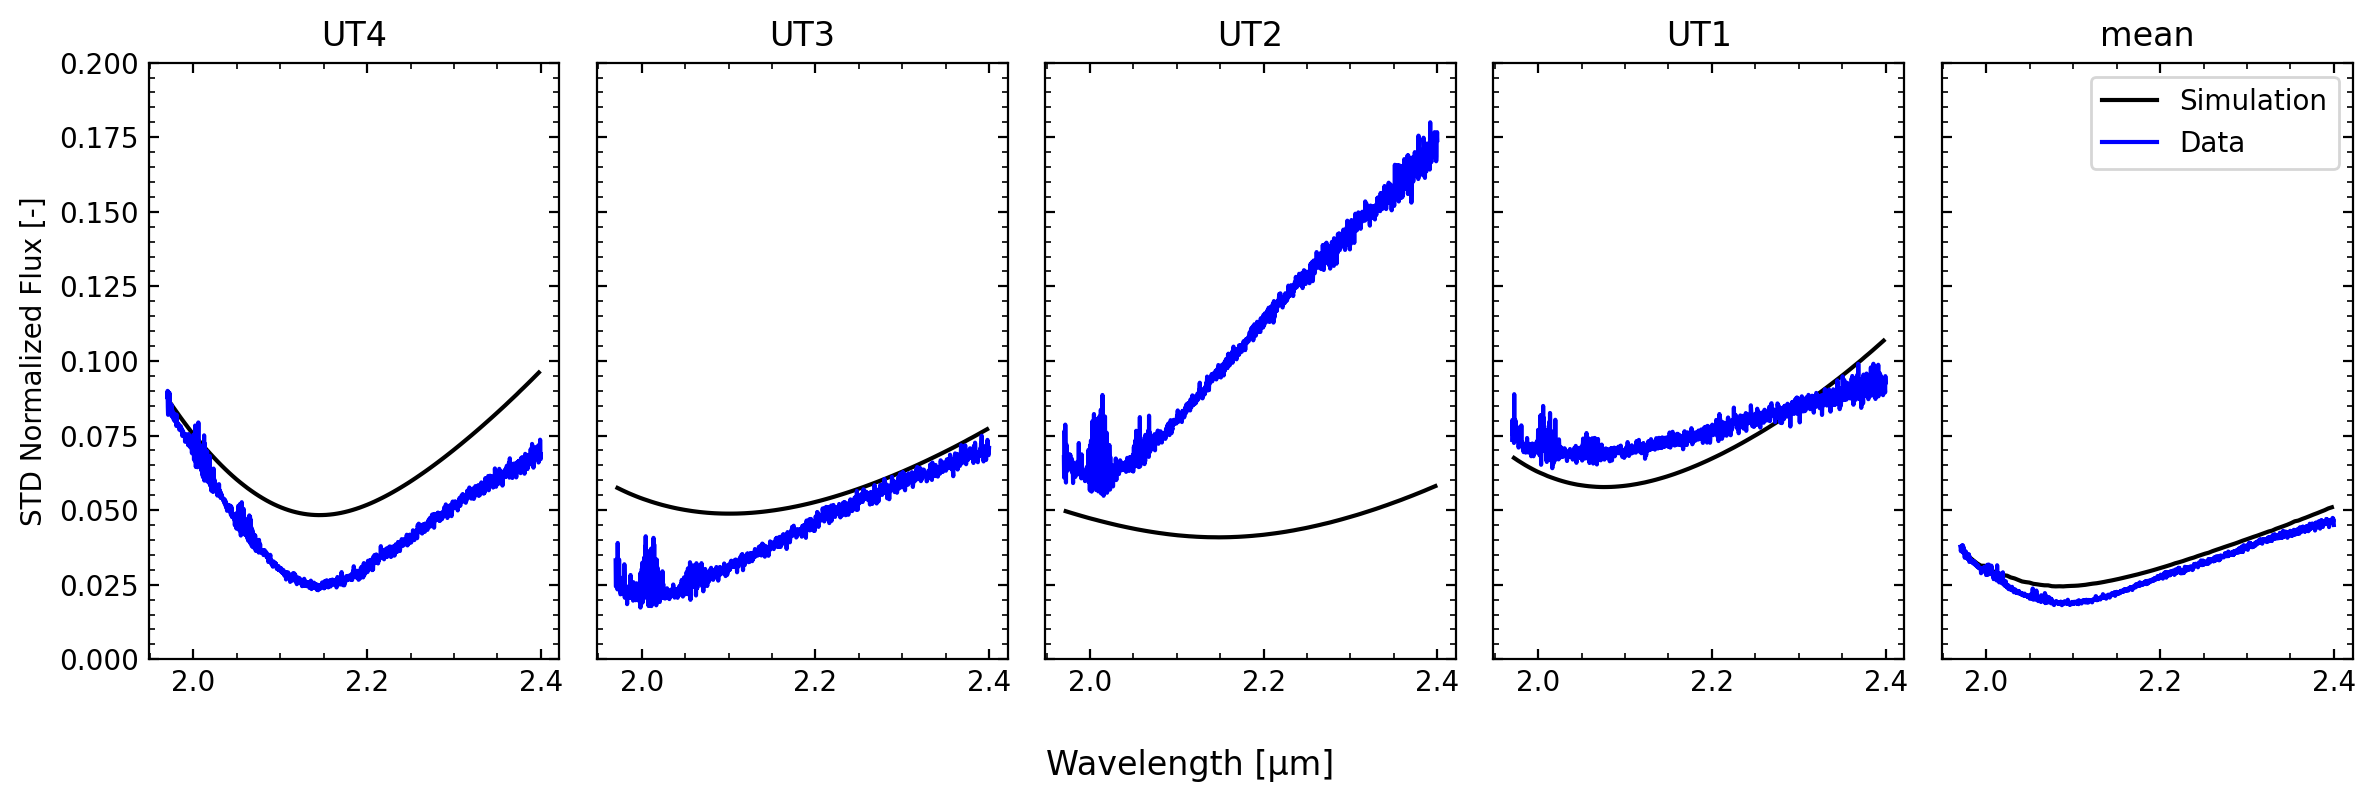

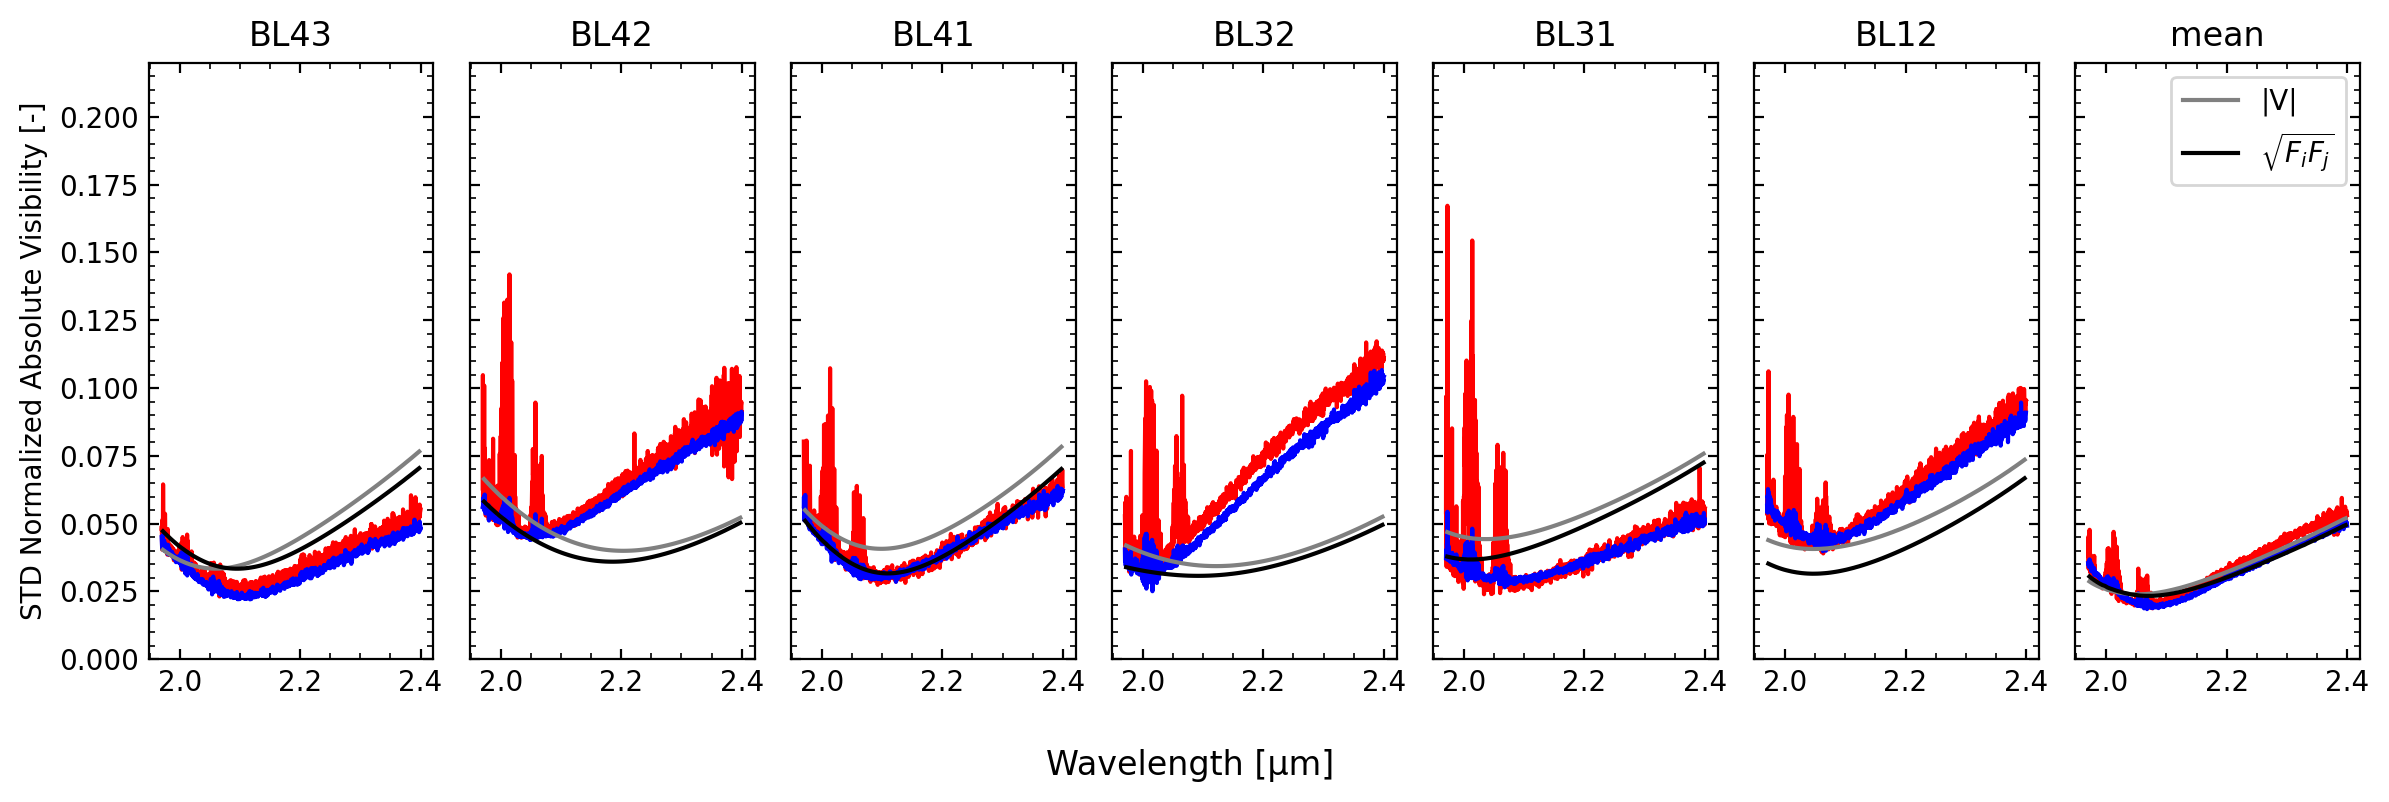

In [46]:
j = 0


fig,ax = plt.subplots(1,5,dpi=200,figsize=(12,4),sharey=True)
for i in range(4):
    ax[i].plot(wave_sim,np.std(flux_sim[:,i]/np.mean(flux_sim[:,i],axis=0)[None,:],axis=0),color='black')
    ax[i].plot(wave*1e6,np.std(flux[j,:,i]/np.mean(flux[j,:,i],axis=0)[None,:],axis=0),color='blue')
    ax[i].set_title(labels[i])
ax[4].plot(wave_sim,np.std(np.mean(flux_sim,axis=1)/np.mean(flux_sim,axis=(0,1))[None,:],axis=0),color='black',label='Simulation')
ax[4].plot(wave*1e6,np.std(np.mean(flux[j],axis=1)/np.mean(flux[j],axis=(0,1))[None,:],axis=0),color='blue',label='Data')
fig.supxlabel("Wavelength [µm]")
ax[0].set_ylabel('STD Normalized Flux [-]')
ax[4].set_title('mean')
ax[0].set_ylim([0.0,0.2])
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
ax[4].legend(loc='upper right')
plt.tight_layout()
plt.show()

vis_flux_sim = np.empty((16,6,100),dtype=np.complex128)
for i in range(6):
    t1 = ind[i][0]
    t2 = ind[i][1]
    vis_flux_sim[:,i] = np.sqrt(flux_sim[:,t1]*flux_sim[:,t2])

fig,ax = plt.subplots(1,7,dpi=200,figsize=(12,4),sharey=True)
for i in range(6):
    ax[i].set_title(bl_labels[i])
    ax[i].plot(wave_sim,np.std(np.abs(vis_sim)[:,i]/np.mean(np.abs(vis_sim)[:,i],axis=0)[None,:],axis=0),color='grey',zorder=100)
    ax[i].plot(wave_sim,np.std(np.abs(vis_flux_sim)[:,i]/np.mean(np.abs(vis_flux_sim)[:,i],axis=0)[None,:],axis=0),color='black',zorder=100)

    ax[i].plot(wave*1e6,np.std(np.abs(vis[j])[:,i]/np.mean(np.abs(vis[j])[:,i],axis=0)[None,:],axis=0),color='red')
    ax[i].plot(wave*1e6,np.std(np.abs(vis_flux[j])[:,i]/np.mean(np.abs(vis_flux[j])[:,i],axis=0)[None,:],axis=0),color='blue')

ax[6].plot(wave_sim,np.std(np.mean(np.abs(vis_sim),axis=1)/np.mean(np.abs(vis_sim),axis=(0,1))[None,:],axis=0),color='grey',label='|V|',zorder=100)
ax[6].plot(wave_sim,np.std(np.mean(np.abs(vis_flux_sim),axis=1)/np.mean(np.abs(vis_flux_sim),axis=(0,1))[None,:],axis=0),color='black',label='$\sqrt{F_iF_j}$',zorder=100)
ax[6].plot(wave*1e6,np.std(np.mean(np.abs(vis[j]),axis=1)/np.mean(np.abs(vis[j]),axis=(0,1))[None,:],axis=0),color='red')
ax[6].plot(wave*1e6,np.std(np.mean(np.abs(vis_flux[j]),axis=1)/np.mean(np.abs(vis_flux[j]),axis=(0,1))[None,:],axis=0),color='blue')
ax[6].legend(loc='upper right')
fig.supxlabel('Wavelength [µm]')
ax[0].set_ylabel('STD Normalized Absolute Visibility [-]')
ax[0].set_ylim([0.0,0.22])
ax[6].set_title('mean')
for a in ax:
    a.tick_params(axis='both', which='both', top=True, right=True, direction='in')
    a.minorticks_on()
plt.tight_layout()
plt.show()

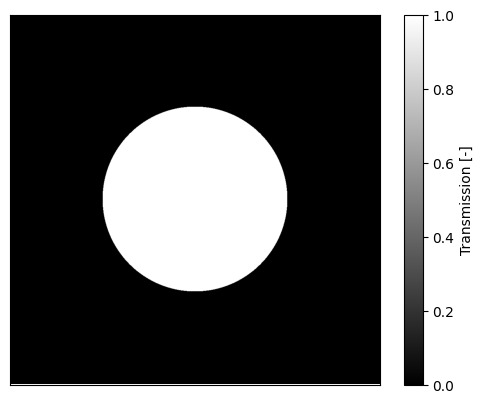

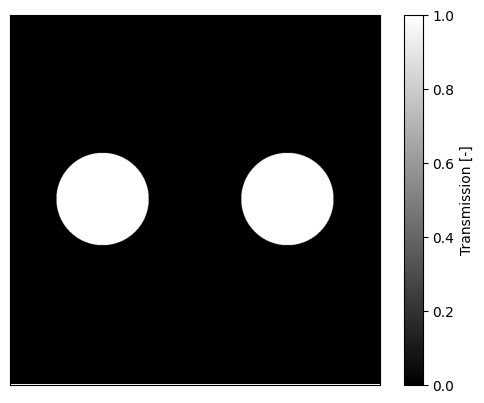

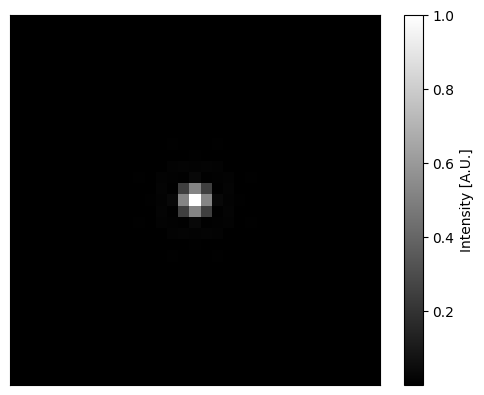

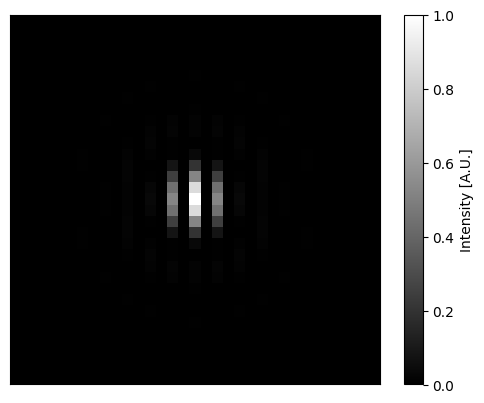

In [45]:
N = 1025
x = np.arange(N)-N//2
X,Y = np.meshgrid(x,x)

R = np.sqrt(X**2+Y**2)

off = 256
R1 = np.sqrt((X-off)**2+Y**2)
R2 = np.sqrt((X+off)**2+Y**2)

Aper = np.zeros((N,N))
Aper[R<256] = 1

Aper12 = np.zeros((N,N))
Aper12[R1<128] = 1
Aper12[R2<128] = 1

fig,ax = plt.subplots()
im = ax.imshow(Aper,cmap='gray')
cb = fig.colorbar(im)
cb.set_label('Transmission [-]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

fig,ax = plt.subplots()
im = ax.imshow(Aper12,cmap='gray')
cb = fig.colorbar(im)
cb.set_label('Transmission [-]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

s = 16
PSF = np.abs(np.fft.fftshift(np.fft.fft2(Aper)))**2
PSF = PSF[N//2-s:N//2+s+1,N//2-s:N//2+s+1]

PSF12 = np.abs(np.fft.fftshift(np.fft.fft2(Aper12)))**2
PSF12 = PSF12[N//2-s:N//2+s+1,N//2-s:N//2+s+1]

fig,ax = plt.subplots()
im = ax.imshow(PSF/np.max(PSF),cmap='gray')
cb = fig.colorbar(im)
cb.set_label('Intensity [A.U.]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

fig,ax = plt.subplots()
im = ax.imshow(PSF12/np.max(PSF12),cmap='gray')
cb = fig.colorbar(im)
cb.set_label('Intensity [A.U.]')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

[0.66686687]


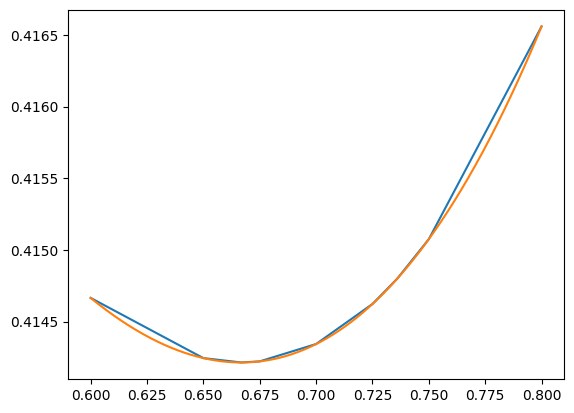

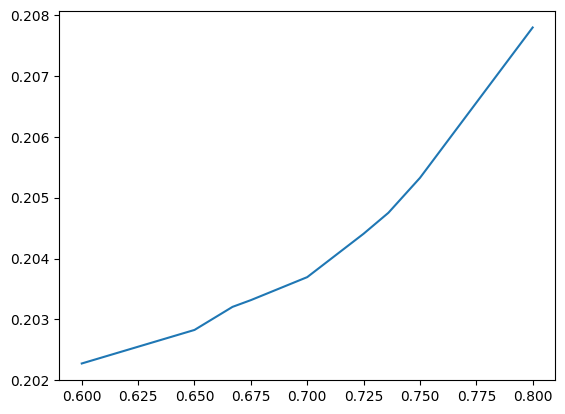

In [ ]:
diam = [0.6,0.65,0.66686687,0.675,0.7,0.725,0.736,0.75,0.8]
residuals_mean = [0.41466535086486833,0.41424529669626126,0.4142148925106247,0.4142225848056249,0.41434362078165893,0.41462290734495355,0.4147997253529054,0.41507521170635736,0.4165590208634499]
residuals_median = [0.20227555505544734,0.20282729496107785,0.20320676637822824,0.20331768801656375,0.203695934490772,0.2044095904666118,0.20475409508053832,0.20532837872197363,0.20780252956049355]

plt.figure()
z = np.polyfit(diam,residuals_mean,3)
d = np.linspace(0.6,0.8,1000)
p = np.poly1d(z)(d)
print(d[p==np.min(p)])
plt.plot(diam,residuals_mean)
plt.plot(d,p)
plt.show()

plt.figure()
plt.plot(diam,residuals_median)
plt.show()

KeyboardInterrupt: 

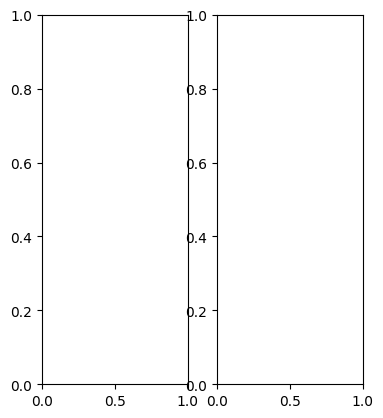

In [ ]:
fig,ax = plt.subplots(1,3,sharey=True)
for i in range(4):
    ax[0].plot(wave,params_opt[i])
for i in range(6):
    ax[1].plot(wave,params_opt[4+i])
for i in range(6):
    ax[2].plot(wave,1/np.sqrt(params_opt[ind[i][0]]*params_opt[ind[i][1]]))
ax[0].set_ylim([0.925,1.1])
plt.show()

fig,ax = plt.subplots(1,3)
for j in range(18):
    for k in range(16):
        for i in range(4):
            ax[0].plot(wave,params_opt[i]*flux[j,k,i],color=f'C{i}')
        for i in range(6):
            ax[1].plot(wave,params_opt[4+i]*np.abs(vis[j,k,i]),color=f'C{i}')
            ax[2].plot(wave,params_opt[4+i]*np.abs(vis[j,k,i])/np.sqrt(params_opt[ind[i][0]]*flux[j,k,ind[i][0]]*params_opt[ind[i][1]]*flux[j,k,ind[i][1]]),color=f'C{i}')
            ax[2].plot(wave,v_ideal[j,k,i],color='white',zorder=100)
ax[2].set_ylim([0.8,1.2])
plt.show()

#"""
# --- Inputs ---
input_fits_path = "/home/sauter/PhD/vlti_gravity_sim/data/V2PM/GRAVI.2024-12-20T10_49_26.376_p2vm.fits"
output_fits_path = "/home/sauter/PhD/beta Pic/P2VM_Calibration/GRAVI.2024-12-20T10_49_26.376_p2vm_calibrated.fits"

data0 = fits.open(input_fits_path)[4].data
tm0 = data0["TRANSMISSION"]
coh0 = data0["COHERENCE"]

# --- Load original file ---
hdul = fits.open(input_fits_path)
hdul_copy = fits.HDUList([hdu.copy() for hdu in hdul])
hdul.close()  # Close original

# --- Compute normalized data (assuming you've already done this part) ---
tm_norm = tm0*params_opt[:4][None]
coh_norm = coh0*params_opt[4:][None]

# --- Overwrite extension data ---
p2vm_data = hdul_copy[4].data  # HDU 4 contains P2VM
p2vm_data["TRANSMISSION"] = tm_norm.astype(np.float32)
p2vm_data["COHERENCE"] = coh_norm.astype(np.float32)

# --- Save new file ---
hdul_copy.writeto(output_fits_path, overwrite=True)
hdul_copy.close()
#"""

In [ ]:
all_files = os.listdir(root)
files = []
for file in all_files:
    if "ASTROREDUCED" in file and "HD95086" in file:
        files.append(file)
files.sort()

vis1 = np.empty((5,16,6,233),dtype=np.complex128)
flux1 = np.empty((5,16,4,233))
v_ideal1 = np.ones((5,16,6,233))

baseline_labels = ["34", "24", "14", "23", "13", "12"]

j = 0
for file in files:
    if fits.open(root+file)[0].header["HIERARCH ESO DET2 SEQ1 DIT"] == 1:

        vis1[j] = fits.open(root+file)[5].data["VISDATA"].reshape(16,6,233)
        flux1[j] = fits.open(root+file)[7].data["FLUX"].reshape(16,4,233)
        wave1 = fits.open(root+file)[1].data["EFF_WAVE"]
        j += 1

# Initial guess
params0 = np.ones(10)

params_opt1 = np.empty((10,233))

for i in range(233):
    print(i)
    # Nonlinear constraint
    constraint = NonlinearConstraint(lambda p: flux_constraint(p, np.abs(vis1[:,:,:,i]), flux1[:,:,:,i]), 0, 0)

    # Run optimization
    result = minimize(
        calibrate_vis,
        params0,
        args=(np.abs(vis1[:,:,:,i]), flux1[:,:,:,i], v_ideal1[:,:,:,i]),
        constraints=[constraint],
        bounds=[(0.5, 2.0)] * 10,
        method='trust-constr',
        options={'gtol': 1e-10, 'xtol': 1e-10, 'verbose': 1}
    )

    params_opt1[:,i] = result.x
    print(result.x)

0
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 605, CG iterations: 124, optimality: 1.03e-07, constraint violation: 3.64e-12, execution time: 0.13 s.
[0.95737671 0.96705772 0.95777565 0.9741651  1.01411848 1.05789374
 1.02135231 1.03292682 1.02963625 1.0101865 ]
1
`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 1375, CG iterations: 273, optimality: 9.10e-08, constraint violation: 0.00e+00, execution time: 0.25 s.
[0.95475289 0.96122748 0.9548936  0.9677161  1.03291886 1.04759717
 1.01832732 1.02944292 1.02664467 1.03026618]
2
`xtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 1133, CG iterations: 280, optimality: 1.03e-07, constraint violation: 0.00e+00, execution time: 0.22 s.
[0.95360813 0.95774953 0.94439651 0.9616398  1.02329154 1.0557331
 1.0215071  1.04108451 1.03256125 1.03586537]
3
`xtol` termination condition is satisfied.
Number of iterations: 78, f

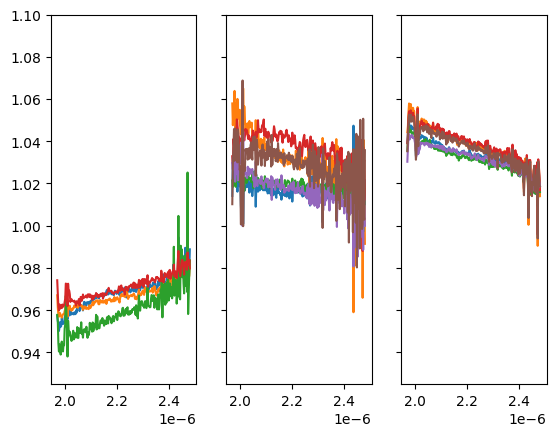

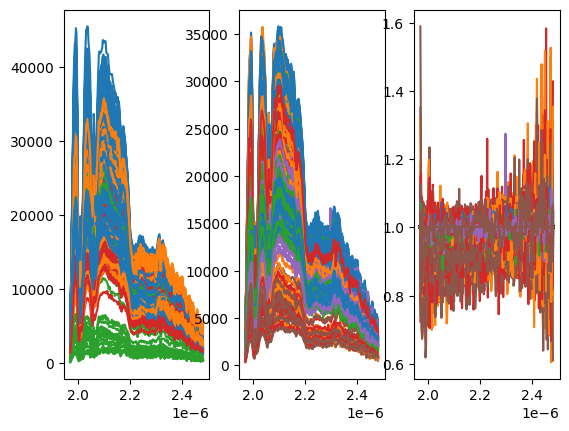

In [ ]:
fig,ax = plt.subplots(1,3,sharey=True)
for i in range(4):
    ax[0].plot(wave1,params_opt1[i])
for i in range(6):
    ax[1].plot(wave1,params_opt1[4+i])
for i in range(6):
    ax[2].plot(wave1,1/np.sqrt(params_opt1[ind[i][0]]*params_opt1[ind[i][1]]))
ax[0].set_ylim([0.925,1.1])
plt.show()

fig,ax = plt.subplots(1,3)
for j in range(5):
    for k in range(16):
        for i in range(4):
            ax[0].plot(wave1,params_opt1[i]*flux1[j,k,i],color=f'C{i}')
        for i in range(6):
            ax[1].plot(wave1,params_opt1[4+i]*np.abs(vis1[j,k,i]),color=f'C{i}')
            ax[2].plot(wave1,params_opt1[4+i]*np.abs(vis1[j,k,i])/np.sqrt(params_opt1[ind[i][0]]*flux1[j,k,ind[i][0]]*params_opt1[ind[i][1]]*flux1[j,k,ind[i][1]]),color=f'C{i}')
            ax[2].plot(wave1,v_ideal1[j,k,i],color=f'C{i}')
plt.show()